In [3]:
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np 
import os 
import glob
import matplotlib.pyplot as plt
from natural_cubic_spline import continuum

In [22]:
import glob
import os
import shutil
path_utiles= '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles'
path_fits = "/home/nacho/molecfit_test/HIP093148/HIP093148_sum/AIR_flux/fsr1.05/"


fits_files = glob.glob(os.path.join(path_fits, '*.fits'))

# rangos de interes
rangos_interes = list(range(43,49))+ list(range(51,58))
rangos_interes = ['m'+str(numeros) for numeros in rangos_interes]

os.makedirs(path_utiles, exist_ok=True)
# extraer los ordenes de echelle utiles
for file in fits_files:
    filename = os.path.basename(file)
    if any(rango in filename for rango in rangos_interes):
        destino = os.path.join(path_utiles,filename)
        shutil.copy(file,destino)
        print(f'copiado:{filename} a {path_utiles}')
    else:
        print(f'no copiado:{filename}')


copiado:HIP093148_sum_m55_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
copiado:HIP093148_sum_m53_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
no copiado:HIP093148_sum_m50_fsr1.05_AIR.fits
copiado:HIP093148_sum_m52_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
copiado:HIP093148_sum_m45_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
copiado:HIP093148_sum_m57_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
copiado:HIP093148_sum_m54_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
no copiado:HIP093148_sum_m42_fsr1.05_AIR.fits
copiado:HIP093148_sum_m46_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
copiado:HIP093148_sum_m47_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes_teluricaAIR_utiles
no copiado:HIP093148_sum_m60_fsr1.05_AIR.fits
copiado:HIP093148_sum_m56_fsr1.05_AIR.fits a /home/nacho/molecfit_test/ordenes

In [6]:
def extraer_datos_originales(archivo_original):
    with fits.open(archivo_original) as hdul:
        data = hdul[0].data
        hdr = hdul[0].header
        n_pix = data.shape[0]
        w = WCS(hdr, naxis = 1)
        long_ond = w.pixel_to_world(np.arange(n_pix)).value
        flux_norm, y_fit, w_excl, f_excl =\
            continuum(long_ond,data,low_rej=1.8,high_re=0.0,niter=10,order=3,plots=False)
        return(long_ond, flux_norm)

def extraer_datos_calctrans(archivo_trans):
    with fits.open(archivo_trans) as hdul:
        data = hdul[1].data
        flux = data['MTRANS']
        long_ond = data['MLAMBDA']*1e4
    return(long_ond, flux)
    
def vac_to_air(wavelength_vac):
    
    wl_vac = np.atleast_1d(wavelength_vac)
    
    sigma2 = (1e4 / wl_vac)**2
    # indice de refracción del aire (n-1) * 10^8
    # n_minus_1 = 6432.8 + 2949810.0 / (146.0 - sigma2) + 25540.0 / (41.0 - sigma2) # edlen 1953
    n_minus_1 = 8343.05 + 2406294.0 / (130.0 - sigma2) + 15999 / (38.9 - sigma2)
    n_minus_1 *= 1e-8
    
    n = 1.0 + n_minus_1
    
    # Conversión de vacío a aire
    wl_air = wl_vac / n
    
    print(f"el indice de refraccion es:{n} ")
    return wl_air
    
def comparar_todo(carpeta_fits, carpeta_corregida, carpeta, archivo_guardar):
    
    """inputs: carpeta_fits: es la carpeta correspondiente a los archivos fits a comparar con 
    la telurica
    carpeta_corregida: carpeta con los archivos corregidos por calctrans
    carpeta: corresponde a la carpeta en la cual están los archivos fits de las teluricas
    archivo_guardar: ruta de la carpeta donde se guardaran las imagenes, esta carpeta puede 
    no existir"""
    
    # Archivo skycalc
    long_sk = []
    flux_sk = []

    for archivo in [
        "/home/nacho/molecfit_test/transmission_J_AUG_AIR.txt", # agregar un _AIR en caso de que sea aire, en VAC solo sacar la extencion
        "/home/nacho/molecfit_test/transmission_Y_AUG_AIR.txt"
    ]:
        with open(archivo, 'r') as txt:
            for linea in txt:
                partes = linea.strip().split()
                if len(partes) >= 2:  # por si hay líneas vacías o mal formadas
                    long_sk.append(float(partes[0]) * 10)
                    flux_sk.append(float(partes[1]))

    # Convertir y ordenar
    long_sk = np.array(long_sk)
    flux_sk = np.array(flux_sk)
    idx = np.argsort(long_sk)
    long_sk = long_sk[idx]
    flux_sk = flux_sk[idx]
    
    # Convertir a arrays numpy para facilitar el manejo
    long_sk = np.array(long_sk)
    flux_sk = np.array(flux_sk)
    
    archivos_telurica = glob.glob(os.path.join(carpeta, '*fits'))
    archivos_telurica.sort()
    
    # Buscar archivos según el patrón especificado
    archivos = glob.glob(os.path.join(carpeta_fits, '*05_AIR.fits')) # modificar VAC por AIR # par_tac_backup_vacuum.fits por aire a vacio
    archivos.sort()

    archivos_corr = glob.glob(os.path.join(carpeta_corregida, '*par_tac.fits')) # par_tac_backup_vacuum.fits por aire a vacio
    archivos_corr.sort()
    
    # Crear directorio para guardar las figuras
    os.makedirs(archivo_guardar, exist_ok=True)
    
    print("Archivos telúricos:", archivos_telurica)
    print("Archivos originales:", archivos)
    print("Archivos corregidos:", archivos_corr)
    
    # Asegurarse de que tenemos el mismo número de archivos
    if len(archivos_telurica) != len(archivos):
        print(f"¡Advertencia! Número diferente de archivos: {len(archivos_telurica)} vs {len(archivos)}")
        
    if len(archivos_corr) != len(archivos):
        print(f"¡Advertencia! Número diferente de archivos corregidos: {len(archivos_corr)} vs {len(archivos)}")
        
    for i, a, j in zip(archivos_telurica, archivos, archivos_corr):
        # Extraer datos telúricos
        long_ond_tel, flux_norm_tel = extraer_datos_originales(i)
        
        # Extraer datos corregidos
        long_ond_corr, flux_corr = extraer_datos_calctrans(j)
        
        nombre_archivo_calctrans = os.path.basename(j).upper()
        print(f"\nProcesando archivo calctrans: {os.path.basename(j)}")
        
        if "AIR" in nombre_archivo_calctrans:
            print(f"Convirtiendo longitud de onda de vacío a aire")
            print(f"    Rango ANTES (vacío): {long_ond_corr.min():.2f} - {long_ond_corr.max():.2f} Å")
            long_ond_corr = vac_to_air(long_ond_corr)
            print(f"    Rango DESPUÉS (aire): {long_ond_corr.min():.2f} - {long_ond_corr.max():.2f} Å")
        else:
            print(f">>> 'AIR' no encontrado, se mantiene en vacío")

        # Extraer datos originales
        long_ond_orig, flux_orig = extraer_datos_originales(a)
        
        # Determinar el rango de longitud de onda considerando también los datos corregidos
        long_min = min(long_ond_orig.min(), long_ond_tel.min(), long_ond_corr.min())
        long_max = max(long_ond_orig.max(), long_ond_tel.max(), long_ond_corr.max())
        
        # Dividir el rango en 4 segmentos
        segmentos = np.linspace(long_min, long_max, 5)
        
        # Crear figura con 4 subplots (2x2)
        fig, axes = plt.subplots(2, 2, figsize=(16, 11))
        axes = axes.flatten()
        
        for idx in range(4):
            # Límites del segmento actual
            lim_inf = segmentos[idx]
            lim_sup = segmentos[idx + 1]
     

            # Máscaras para cada segmento
            mask_corr = (long_ond_corr >= lim_inf) & (long_ond_corr <= lim_sup)
            mask_orig = (long_ond_orig >= lim_inf) & (long_ond_orig <= lim_sup)
            mask_tel = (long_ond_tel >= lim_inf) & (long_ond_tel <= lim_sup)
            mask_sk = (long_sk >= lim_inf) & (long_sk <= lim_sup)
            # Filtrar datos originales para este segmento
            
            long_seg_orig = long_ond_orig[mask_orig]
            flux_seg_orig = flux_orig[mask_orig]

            # Filtrar datos corregidos para este segmento 
            
            long_seg_corr = long_ond_corr[mask_corr]
            flux_seg_corr = flux_corr[mask_corr]
            
            # Filtrar datos telúricos para este segmento
            
            long_seg_tel = long_ond_tel[mask_tel]
            flux_seg_tel = flux_norm_tel[mask_tel]
            
            # Filtrar datos skycalc para este segmento
            
            long_seg_sk = long_sk[mask_sk]
            flux_seg_sk = flux_sk[mask_sk]
            
            # Graficar en el subplot correspondiente con colores distintivos
            #axes[idx].plot(long_seg_orig, flux_seg_orig, label='Flujo original', 
                          #alpha=0.6, linewidth=1.5, color='blue')
            axes[idx].plot(long_seg_corr, flux_seg_corr, label='transmision de molecfit', 
                          alpha=0.7, linewidth=1.5, color='red')
            axes[idx].plot(long_seg_tel, flux_seg_tel, label='Telúrico normalizado', 
                          alpha=0.5, linewidth=1, color='green')
            
            # Graficar skycalc solo si hay datos en este segmento
            if len(long_seg_sk) > 0:
                axes[idx].plot(long_seg_sk, flux_seg_sk, label='Skycalc', 
                              alpha=0.6, linestyle='--', linewidth=1.2, color='orange')
            
            axes[idx].set_title(f"Segmento {idx+1}: {lim_inf:.2f} - {lim_sup:.2f} Å", 
                               fontsize=11, fontweight='bold')
            axes[idx].set_xlabel("Longitud de onda (Å)", fontsize=10)
            axes[idx].set_ylabel("Flujo normalizado", fontsize=10)
            axes[idx].legend(loc='best', fontsize=9)
            axes[idx].grid(True, alpha=0.3, linestyle=':')
            
            # Calcular desplazamiento promedio si ambos tienen datos
           
        
        fig.suptitle(f"Telúrico: {os.path.basename(i)}\n" + 
                     f"Original: {os.path.basename(a)}\n" +
                     f"Corregido: {os.path.basename(j)}", 
                     fontsize=12, y=0.995, fontweight='bold')
        plt.tight_layout()
        
        # Guardar figura
        nombre_archivo = f"{os.path.splitext(os.path.basename(a))[0]}_comparacion_completa.png"
        ruta_completa = os.path.join(archivo_guardar, nombre_archivo)
        plt.savefig(ruta_completa, dpi=150, bbox_inches='tight')
        print(f"Guardado: {ruta_completa}")
        
        plt.show()
        plt.close(fig)  # Cerrar la figura para liberar memoria

Archivos telúricos: ['/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m43_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m44_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m45_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m46_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m47_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m48_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m51_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m52_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m53_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m54_fsr1.05_VAC.fits', '/home/nacho/molecfit_test/ordenes_telurica_utiles/HIP093148_sum_m55_fsr1.05_VAC.fits', '/home/nach

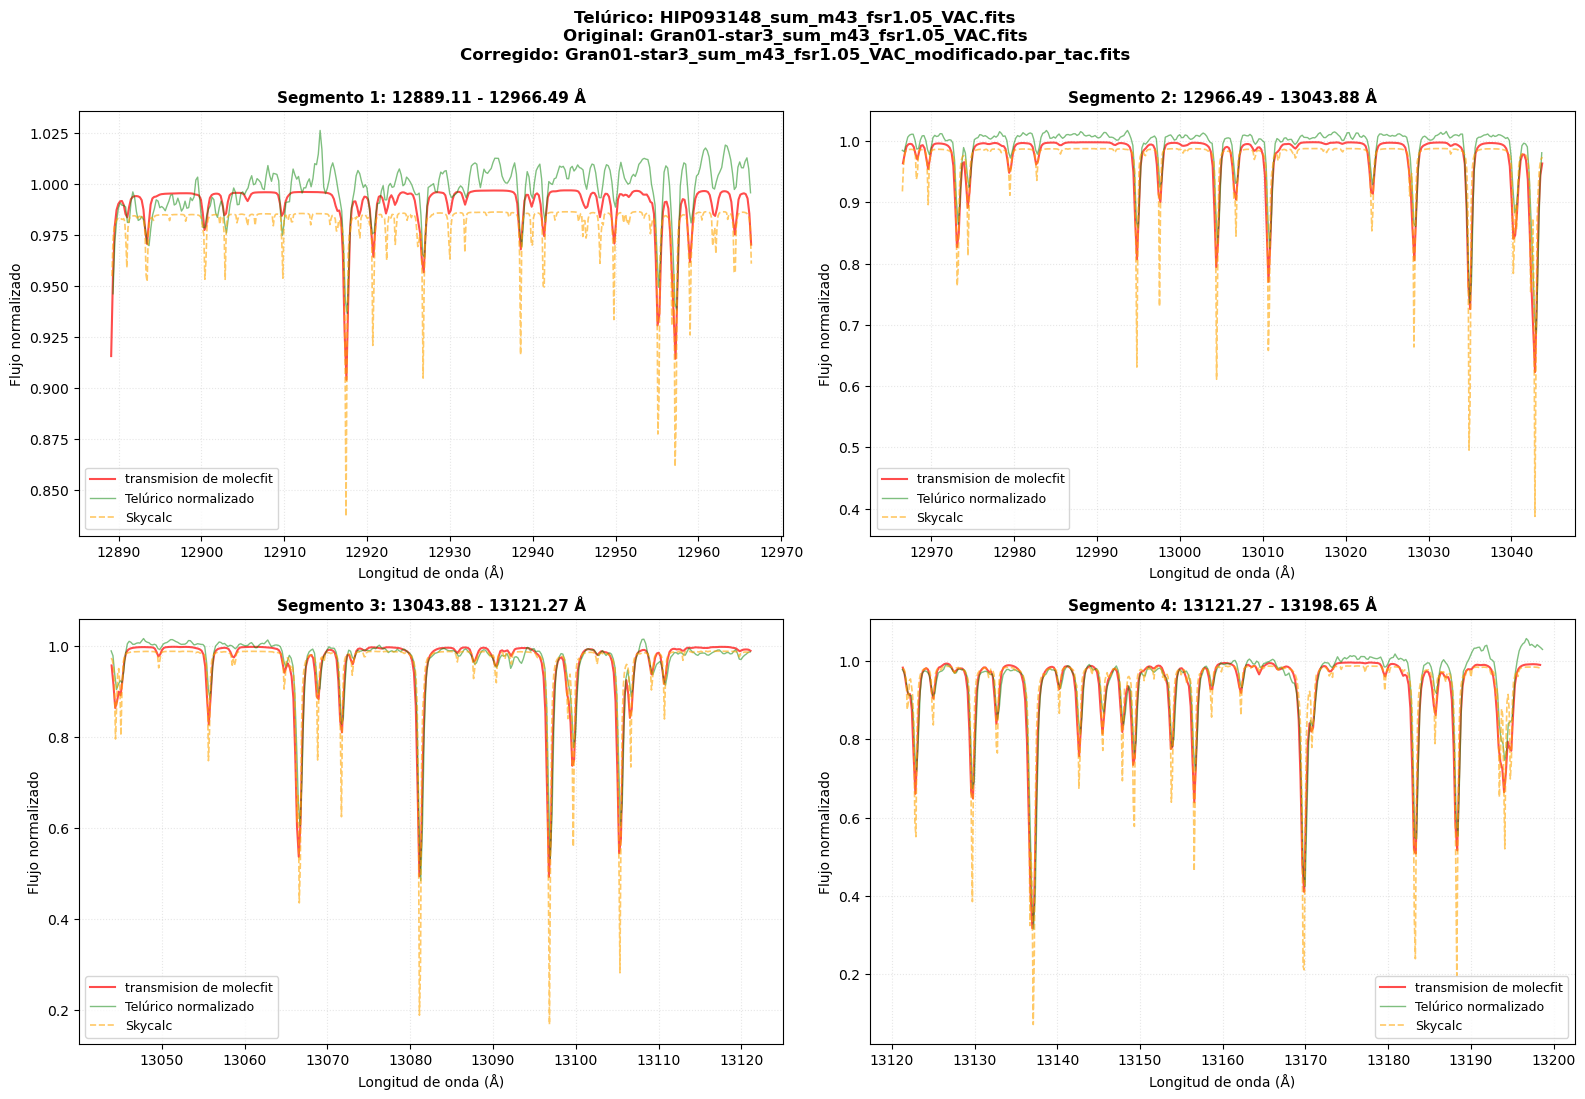

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m44_fsr1.05_VAC_comparacion_completa.png


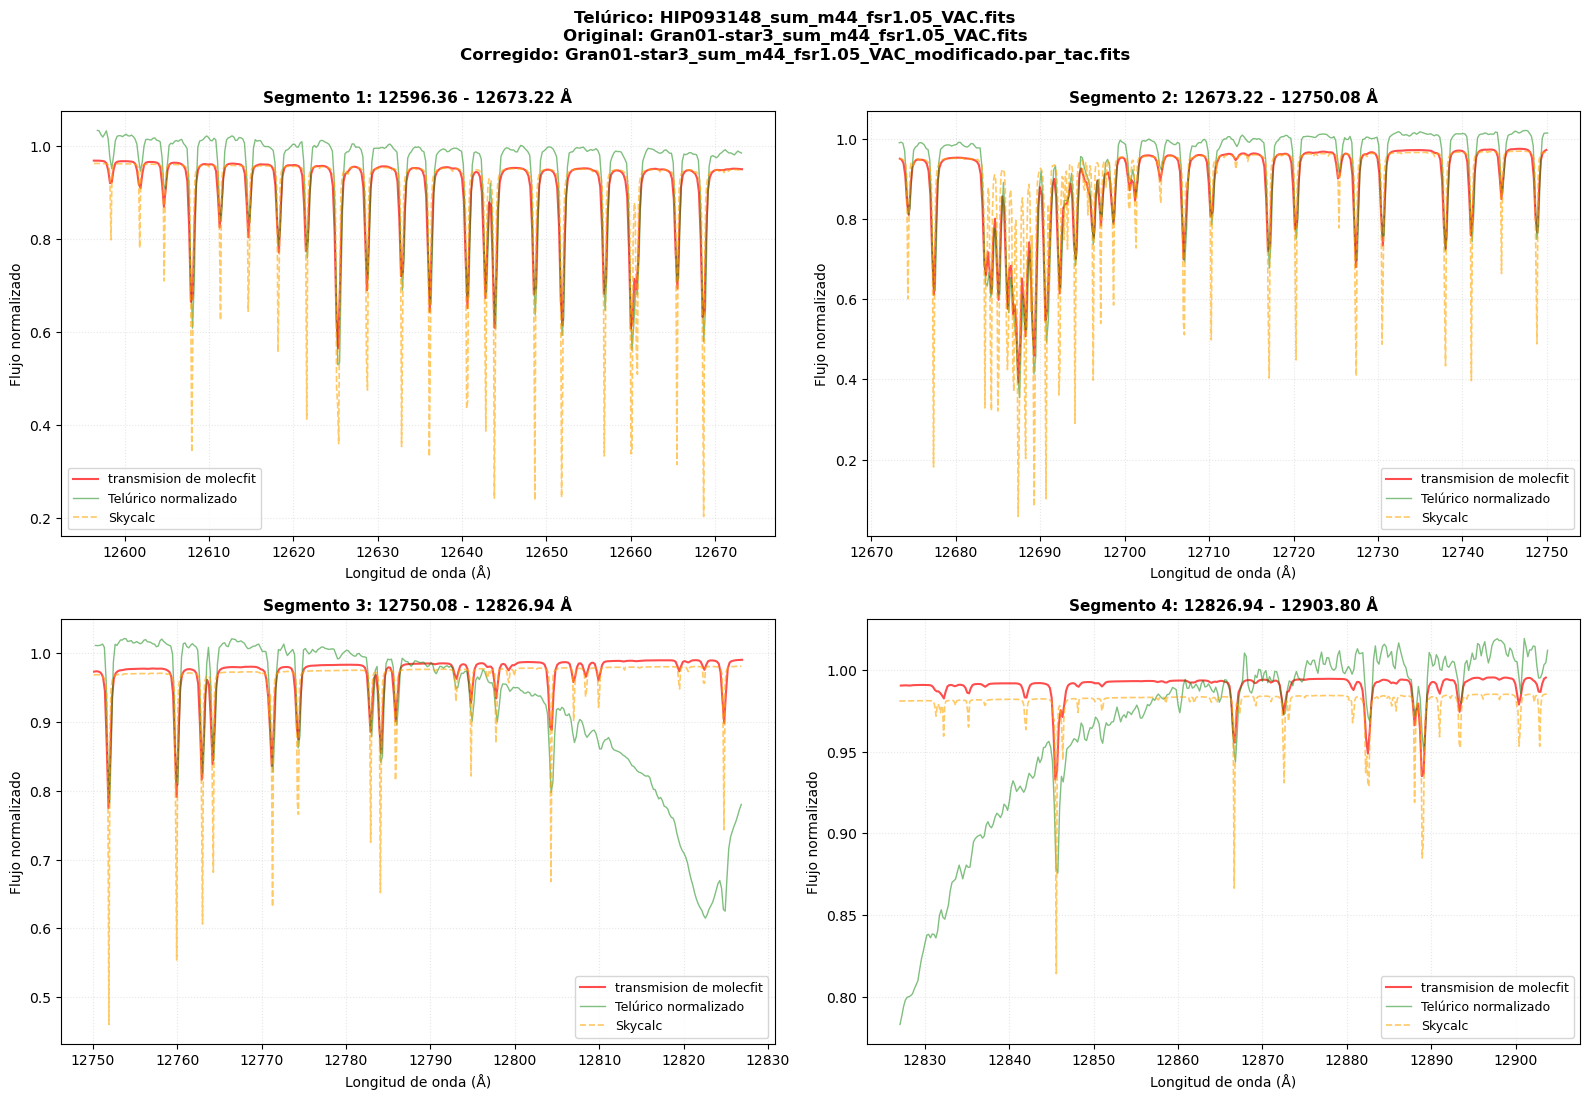

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m45_fsr1.05_VAC_comparacion_completa.png


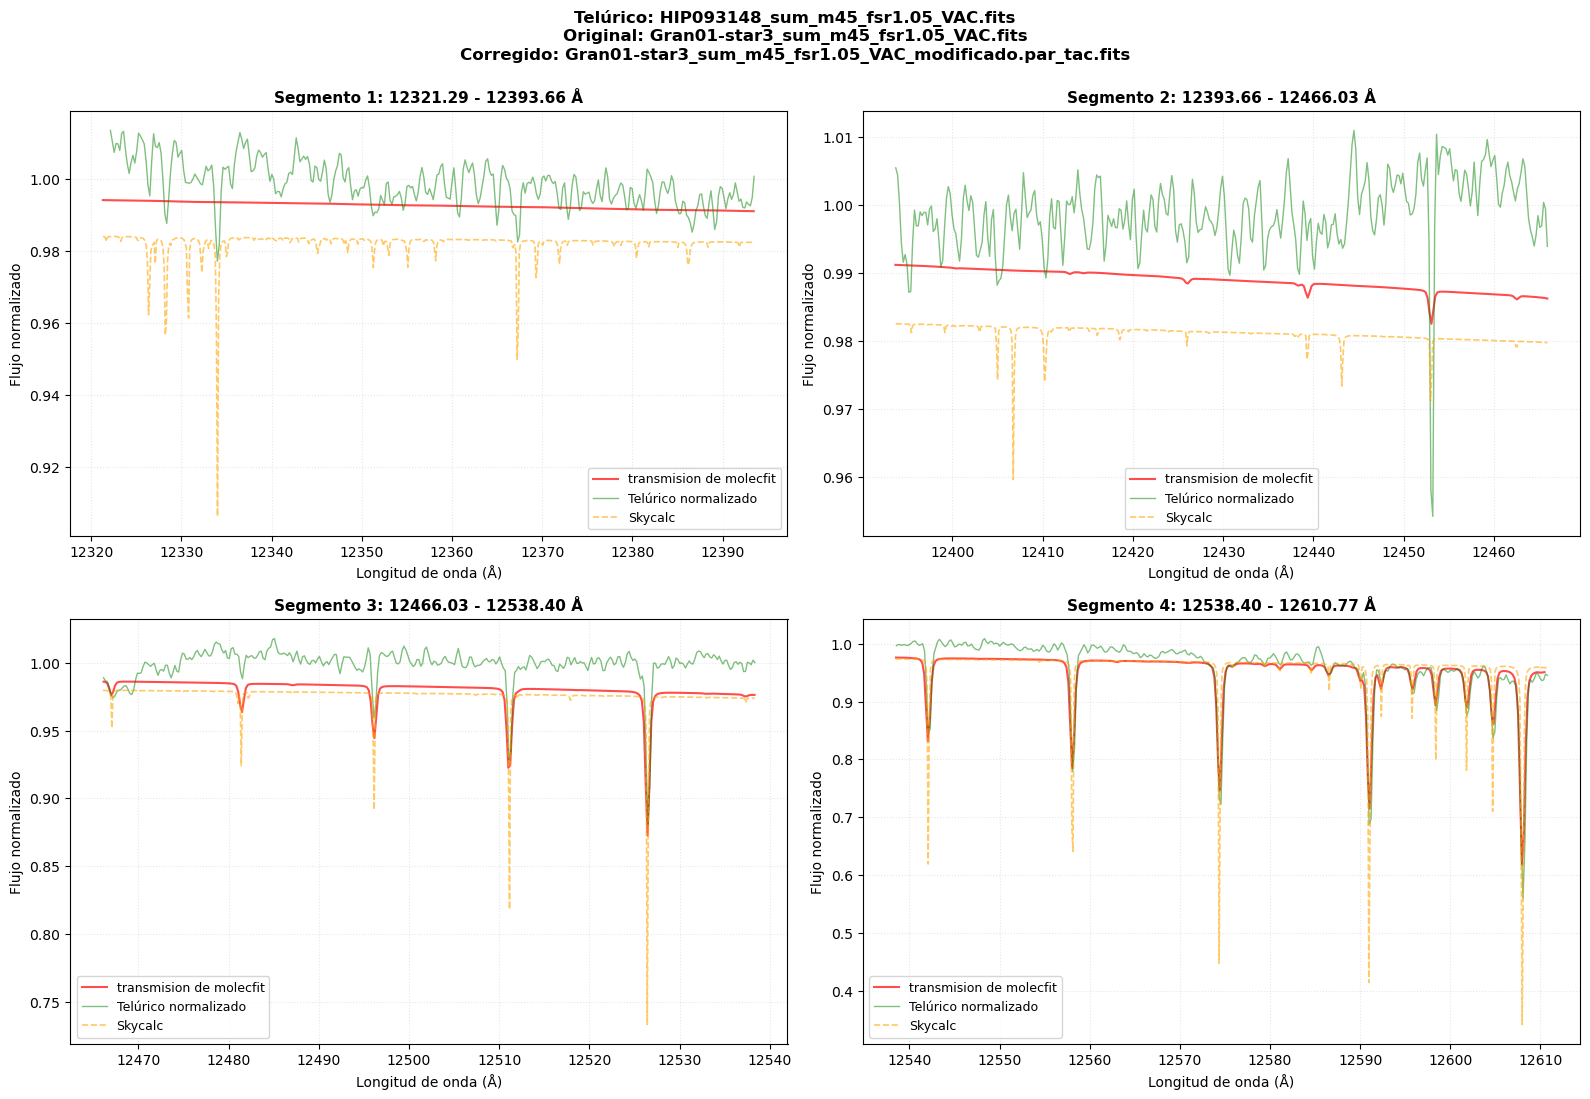

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m46_fsr1.05_VAC_comparacion_completa.png


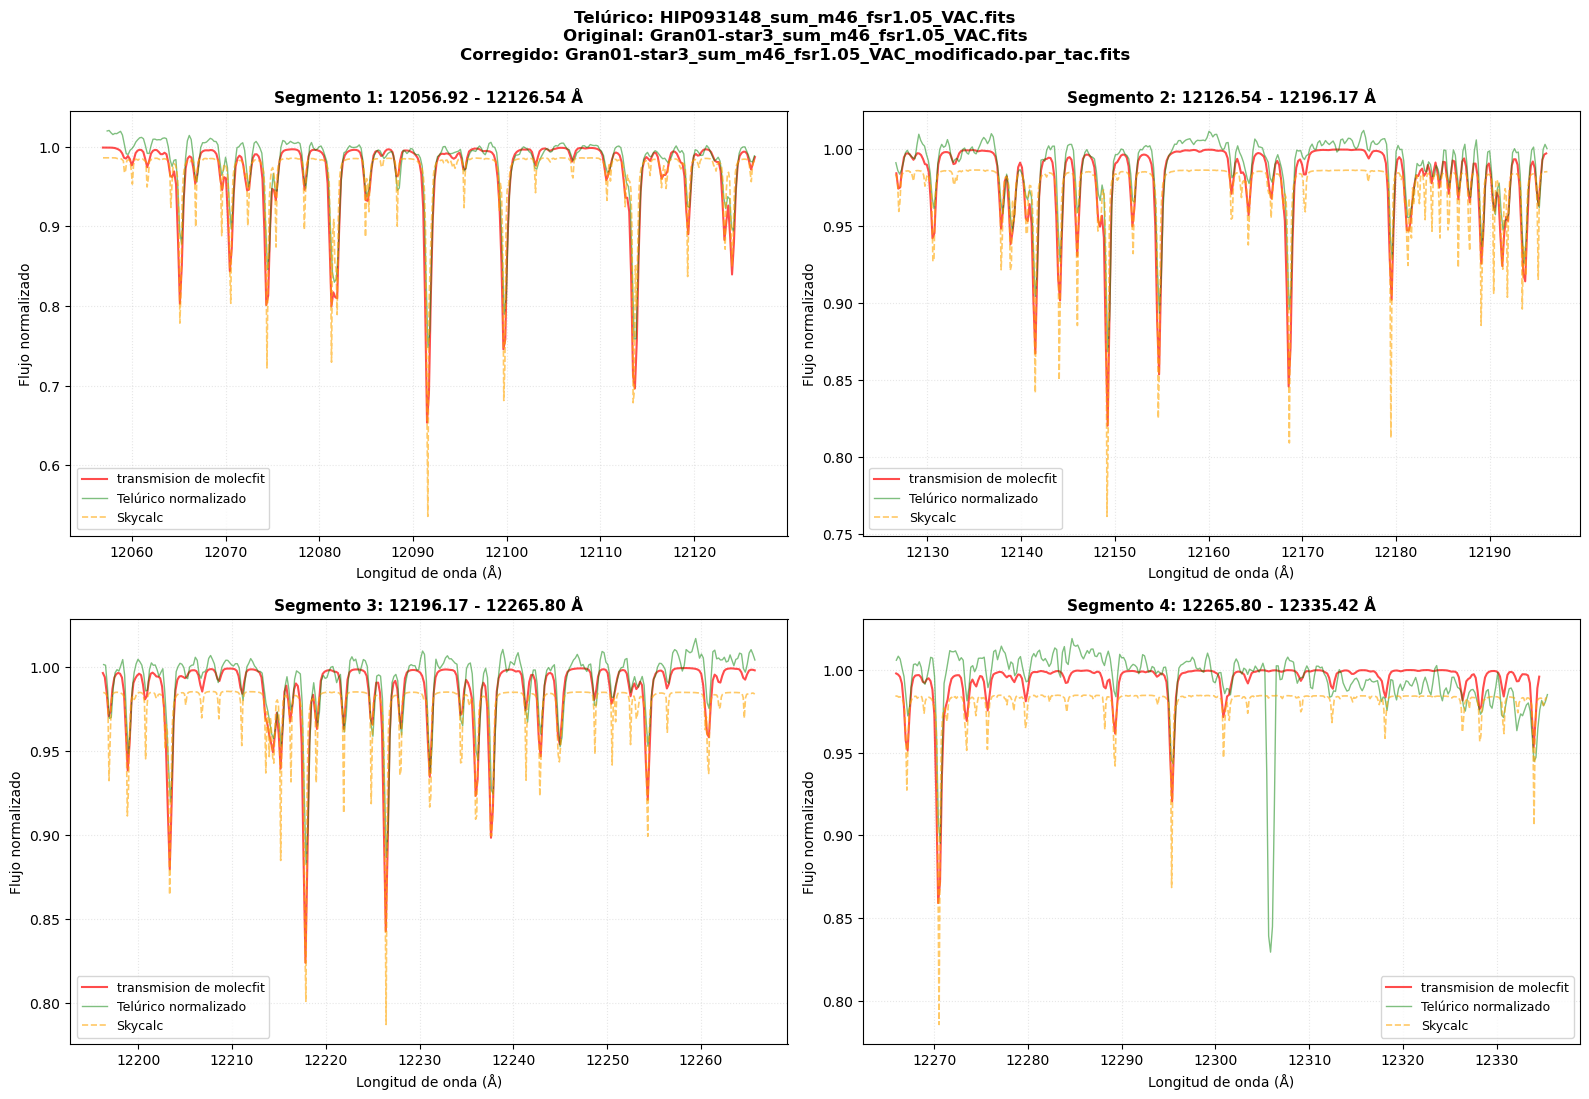

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m47_fsr1.05_VAC_comparacion_completa.png


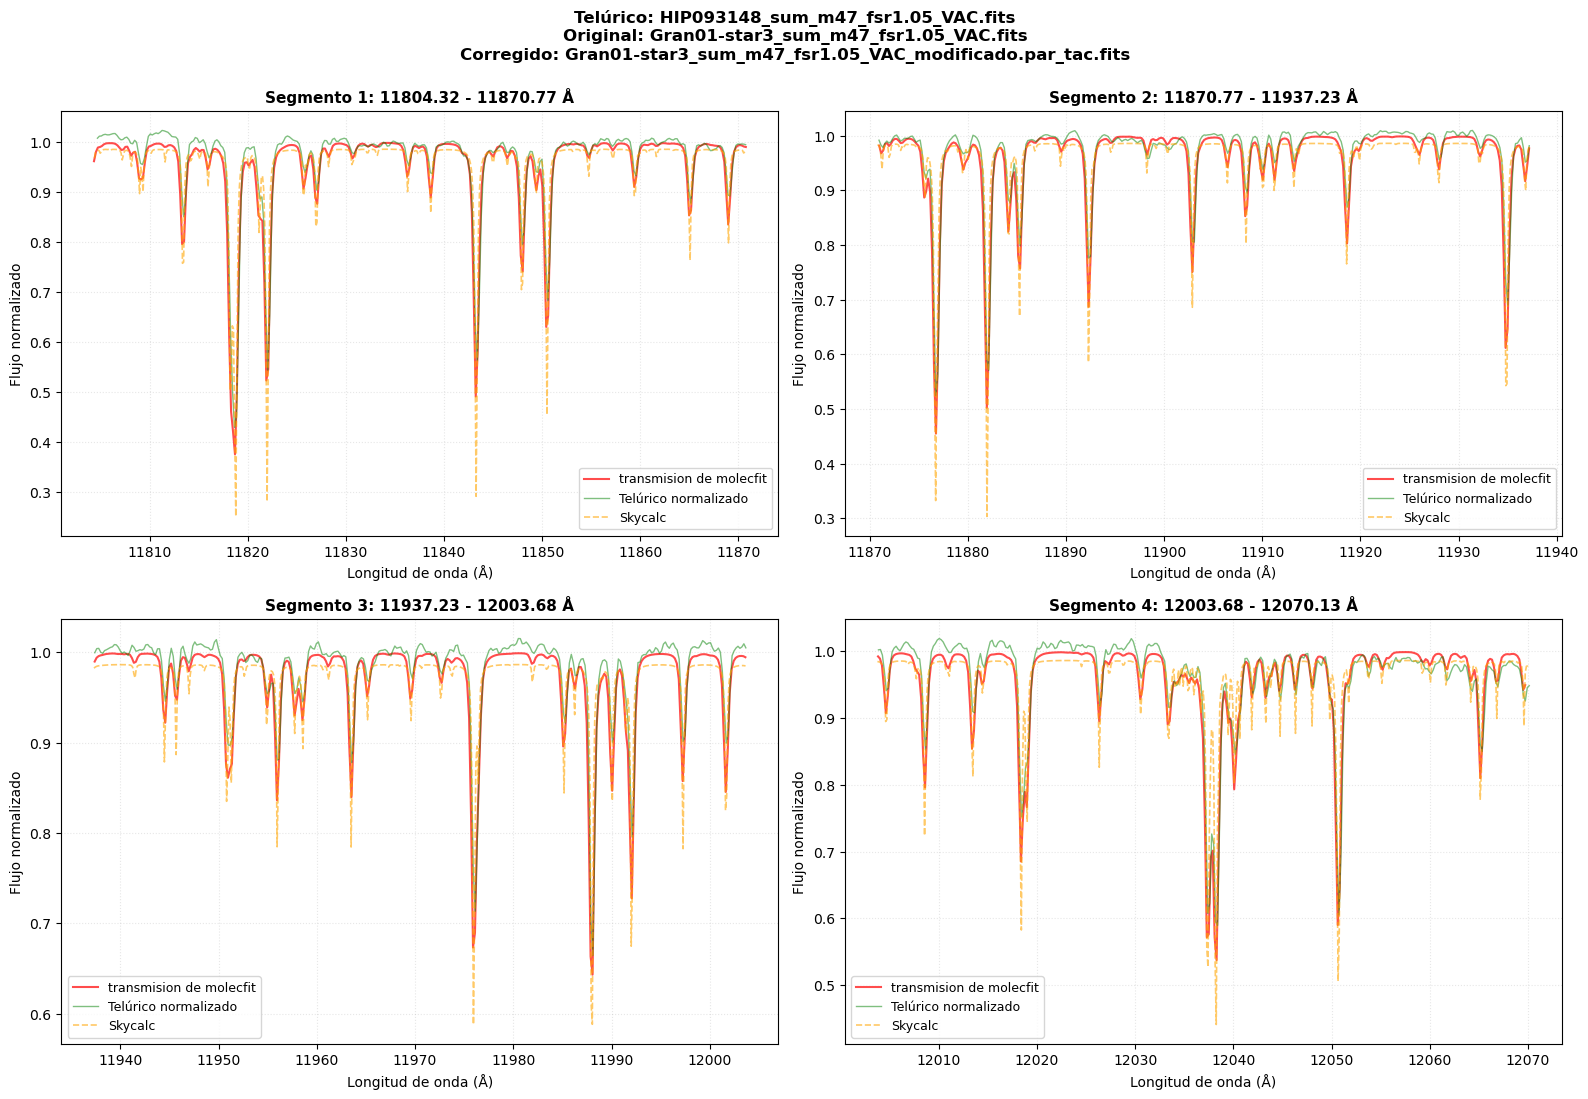

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m48_fsr1.05_VAC_comparacion_completa.png


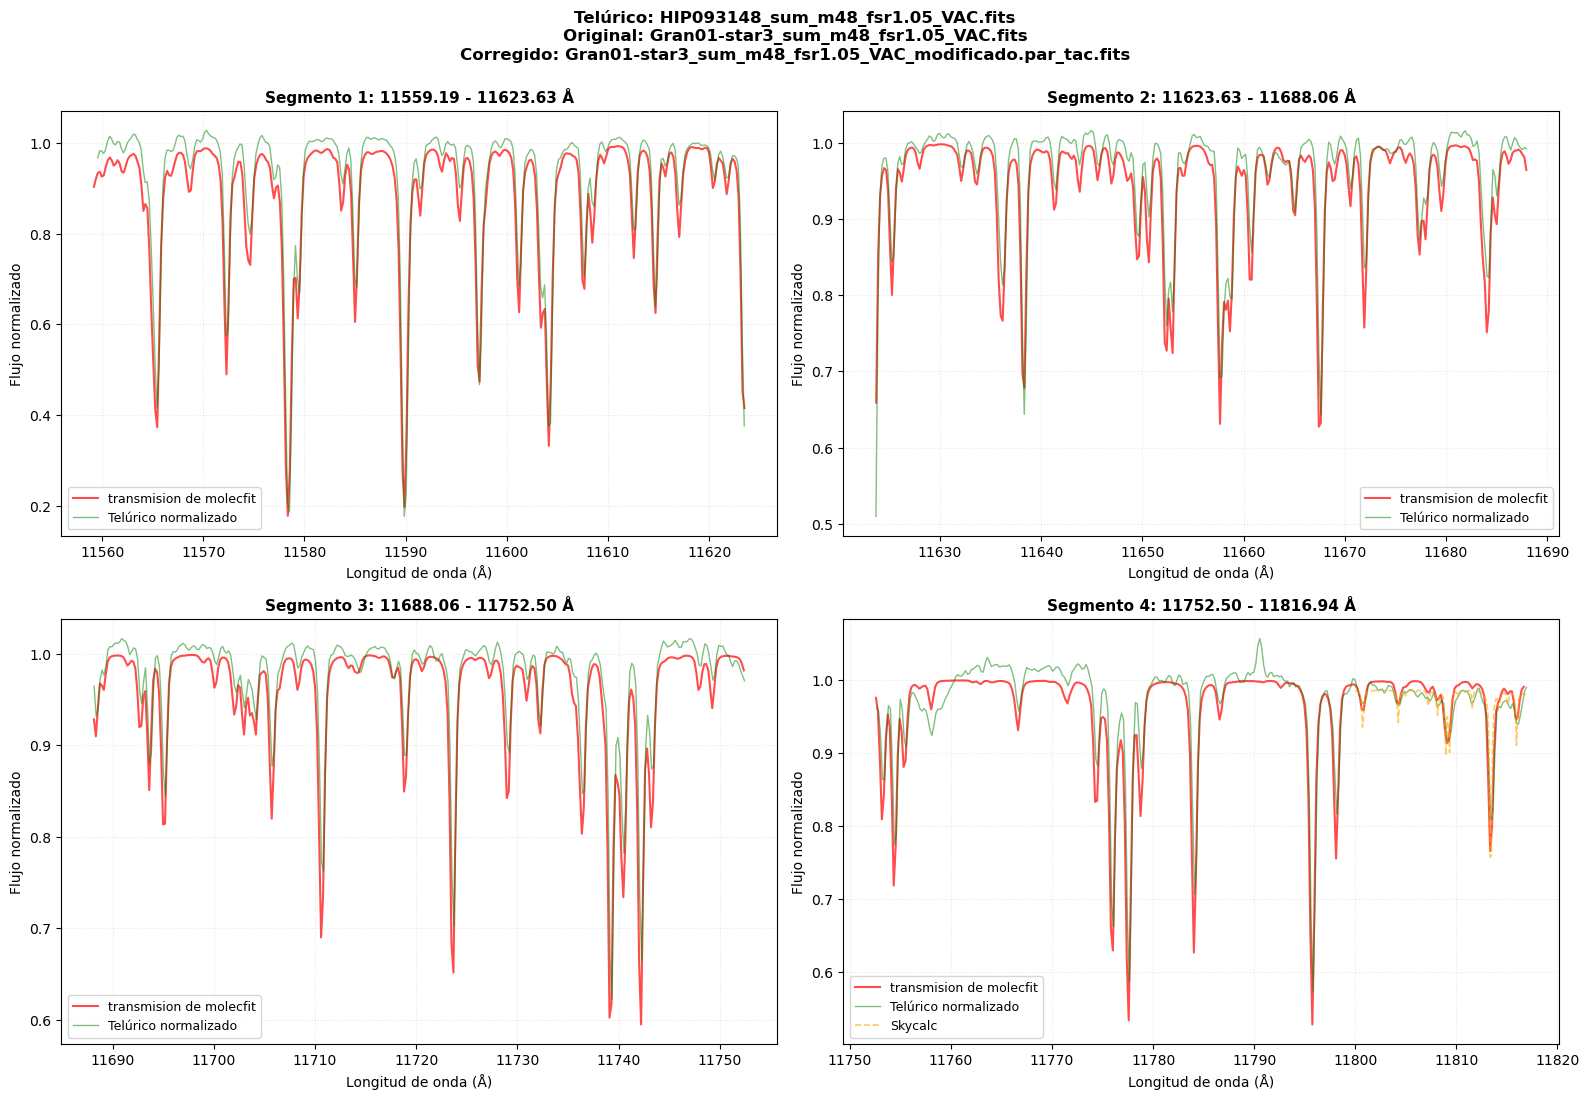

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m51_fsr1.05_VAC_comparacion_completa.png


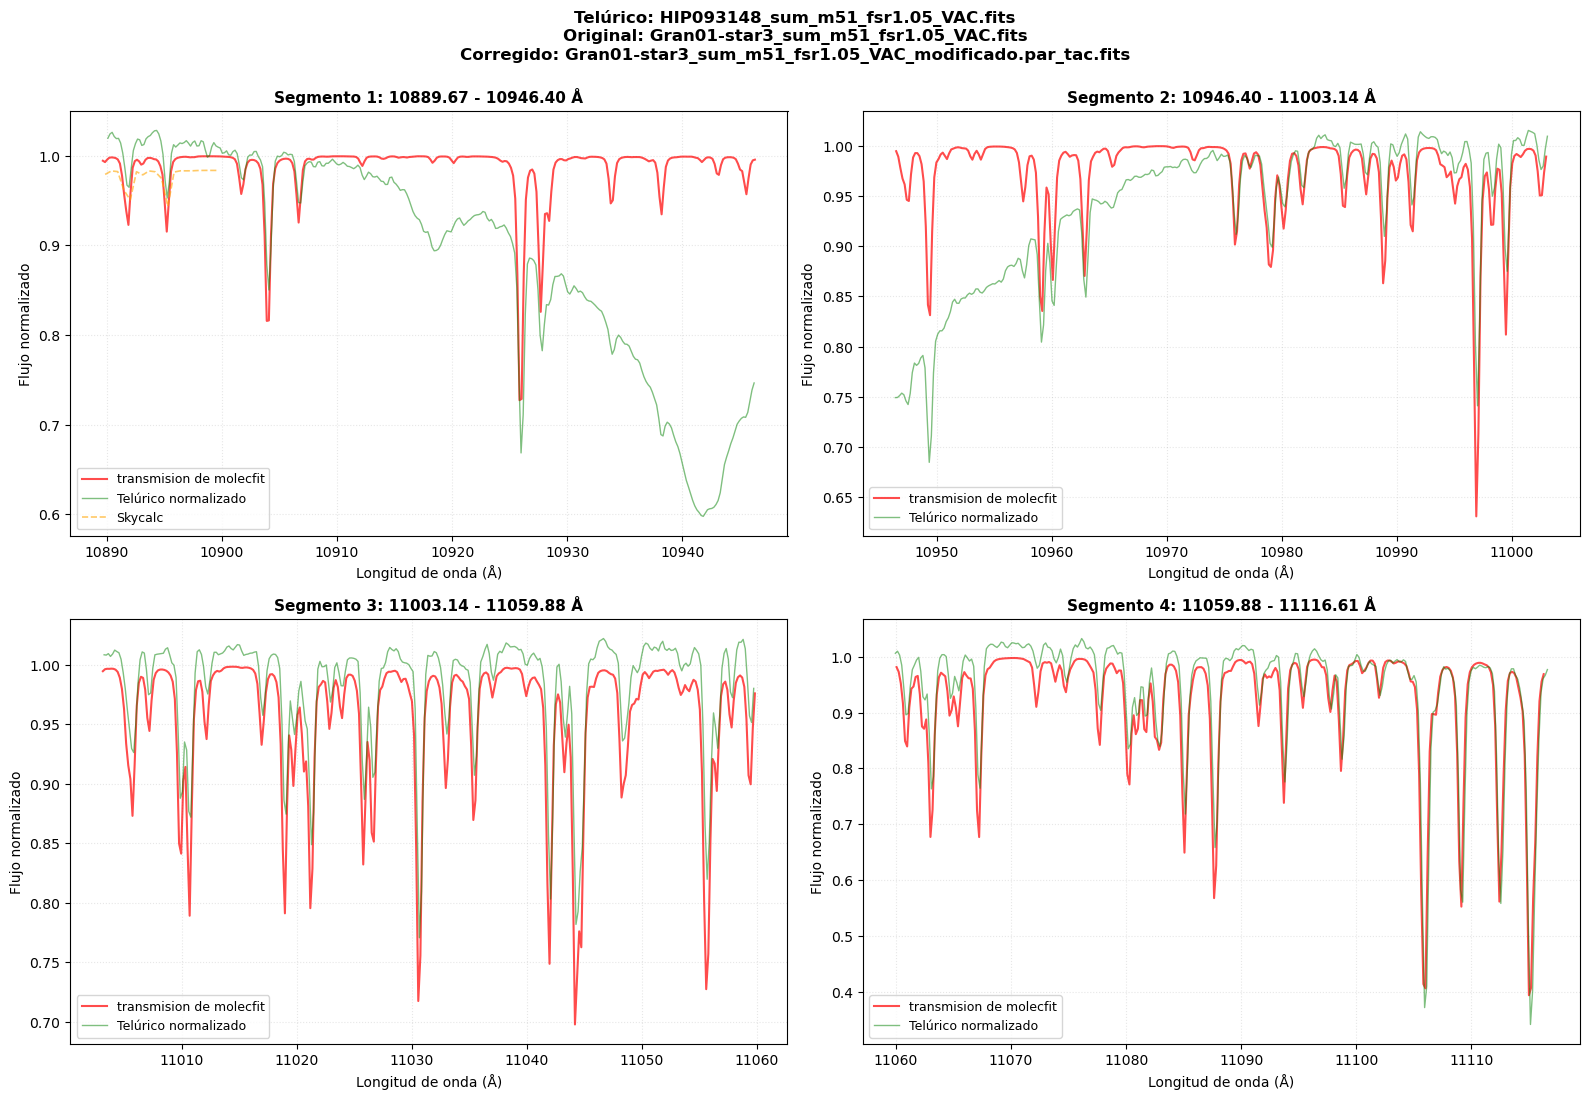

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m52_fsr1.05_VAC_comparacion_completa.png


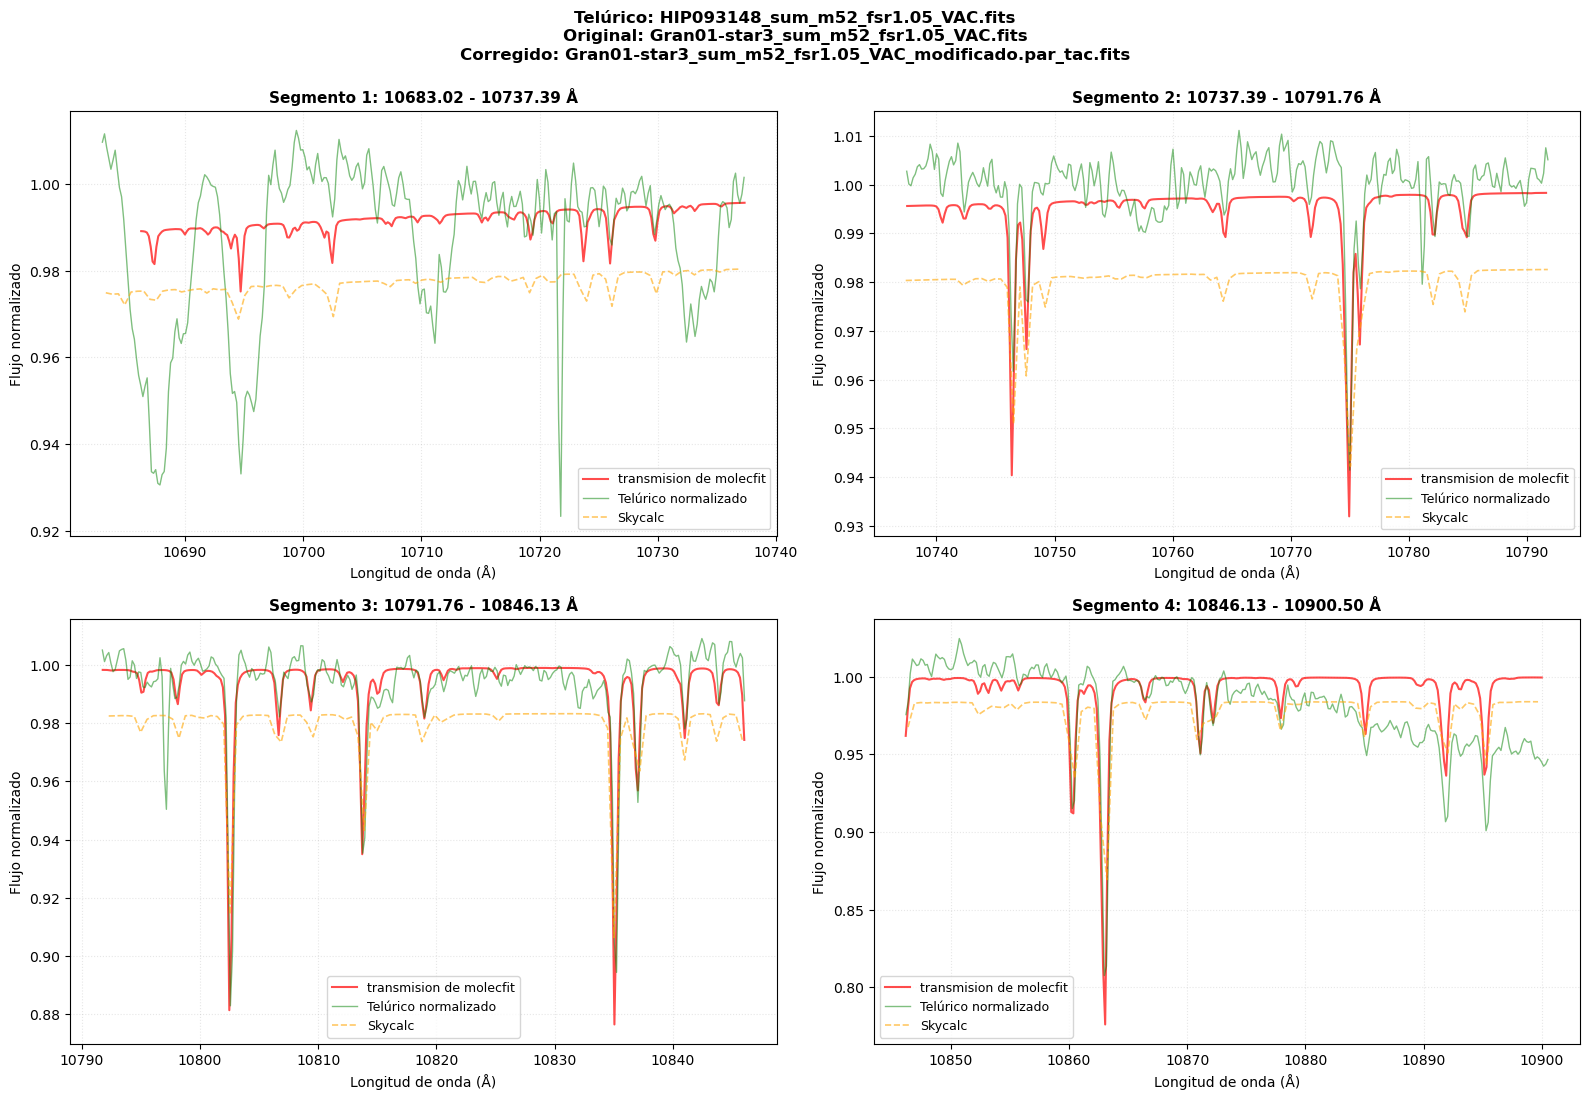

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m53_fsr1.05_VAC_comparacion_completa.png


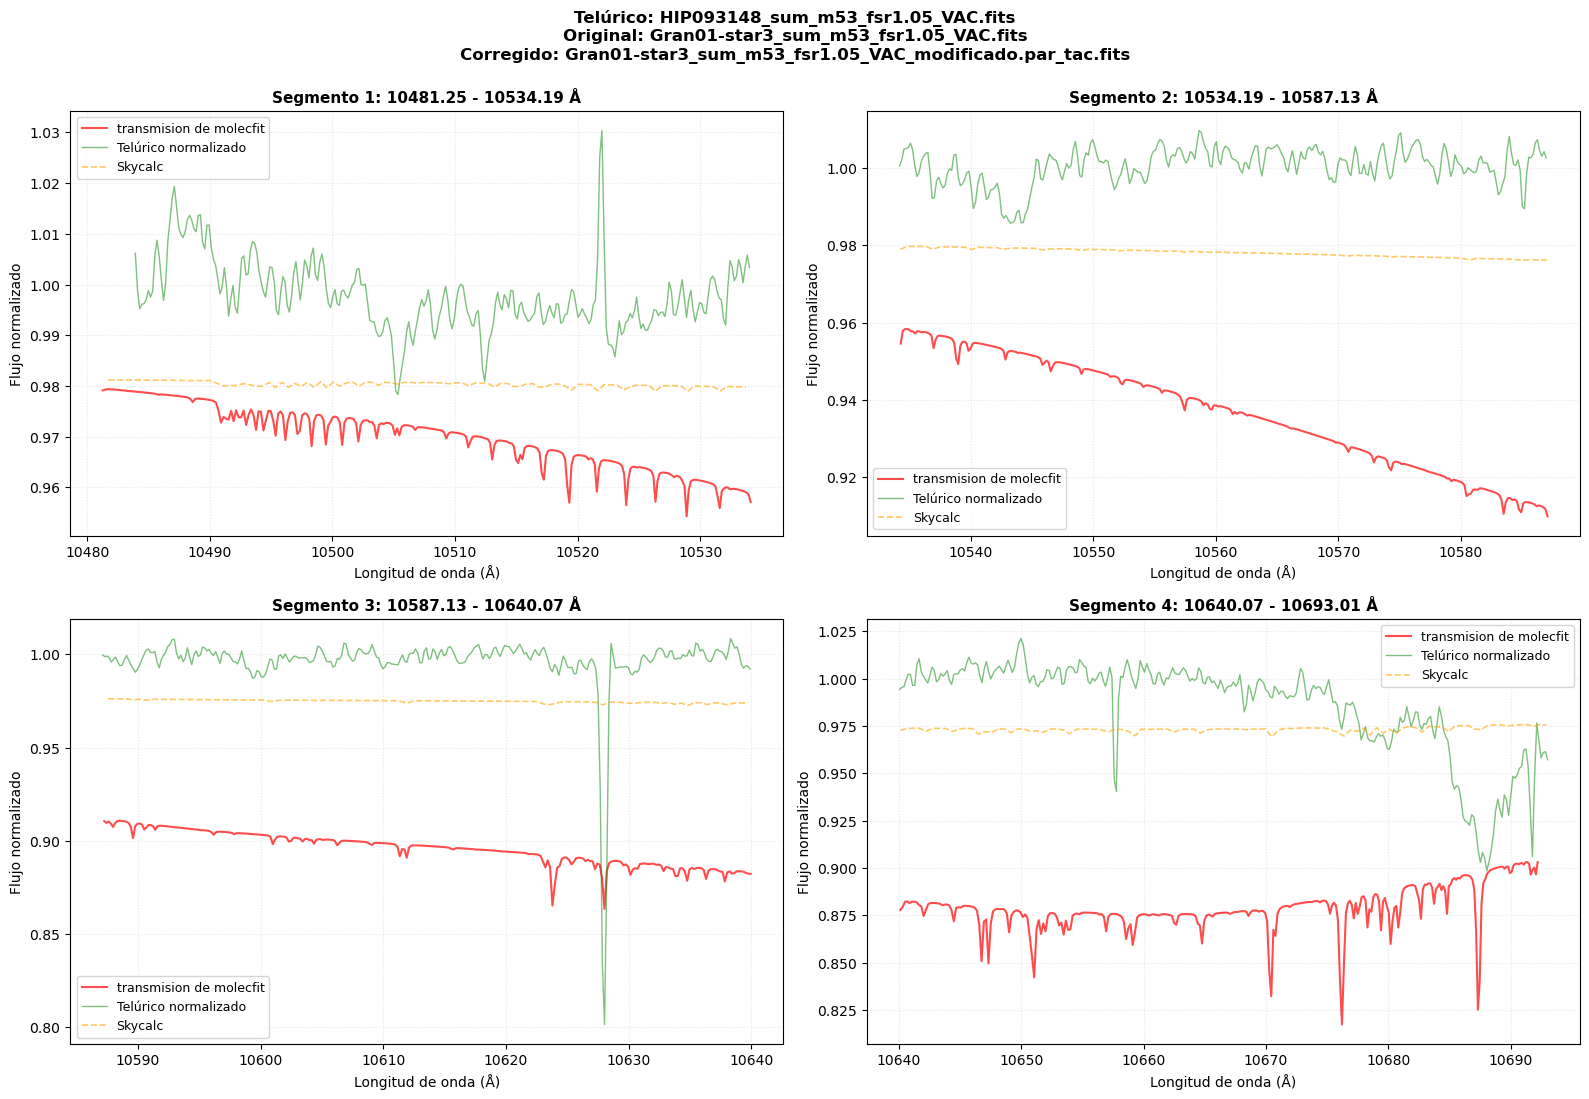

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m54_fsr1.05_VAC_comparacion_completa.png


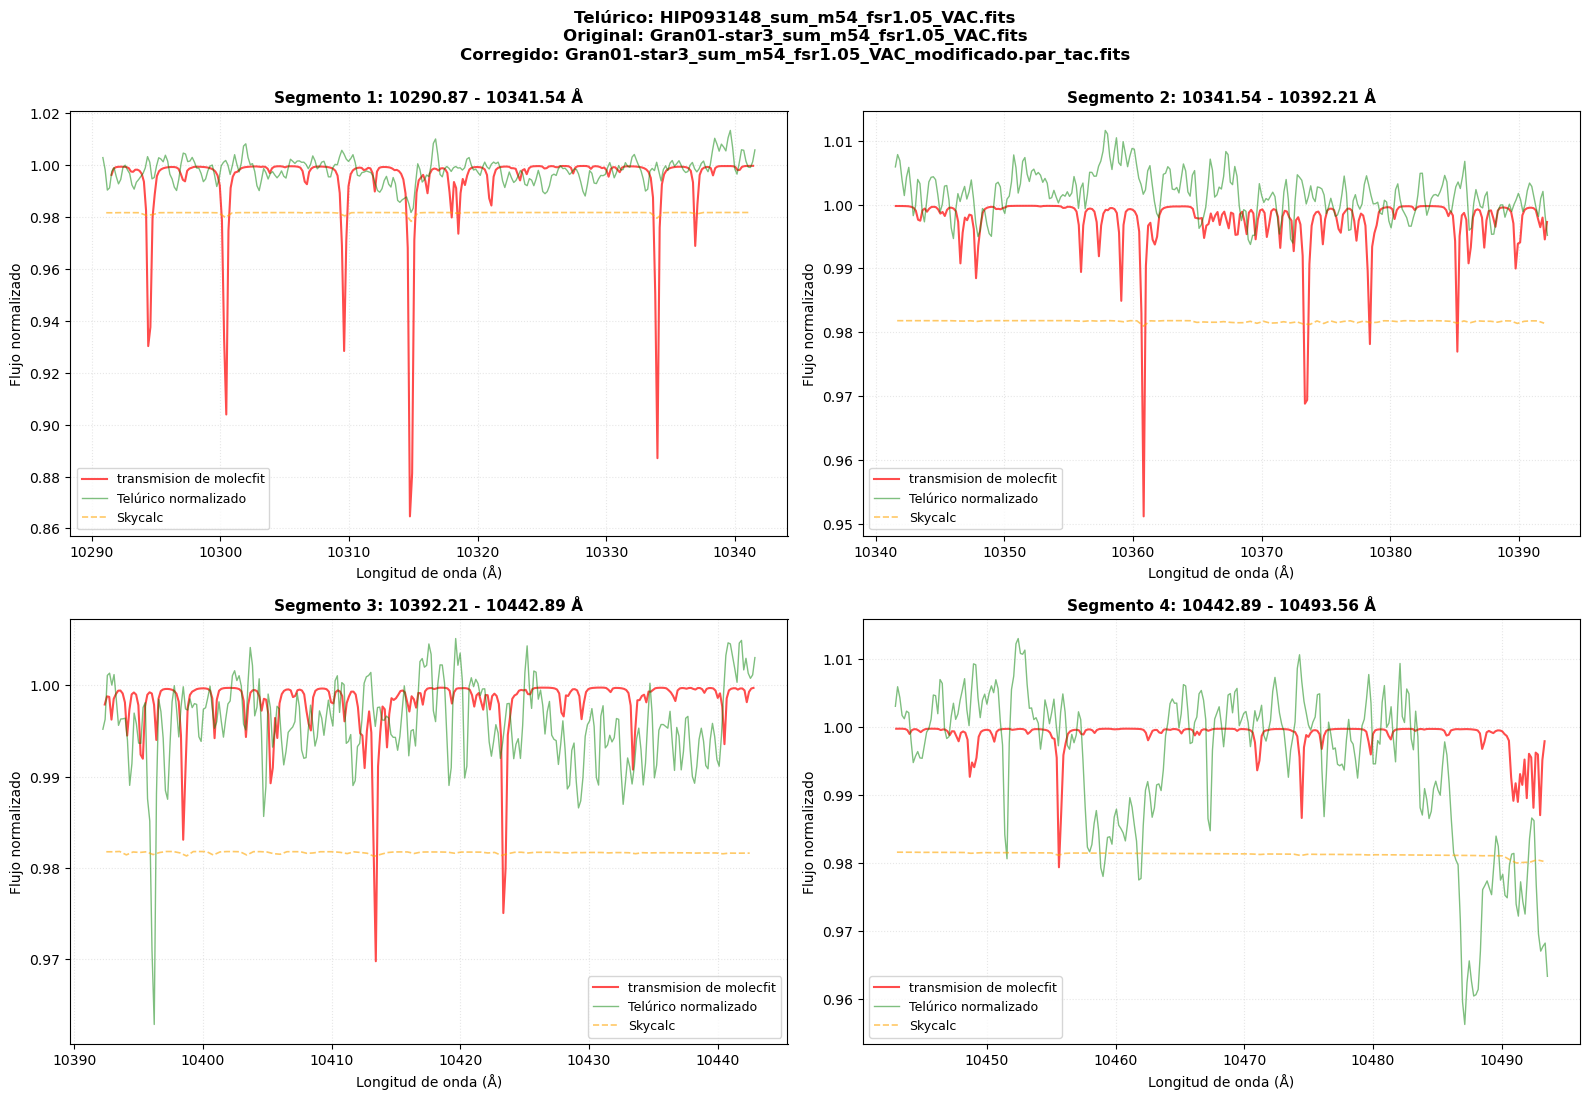

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m55_fsr1.05_VAC_comparacion_completa.png


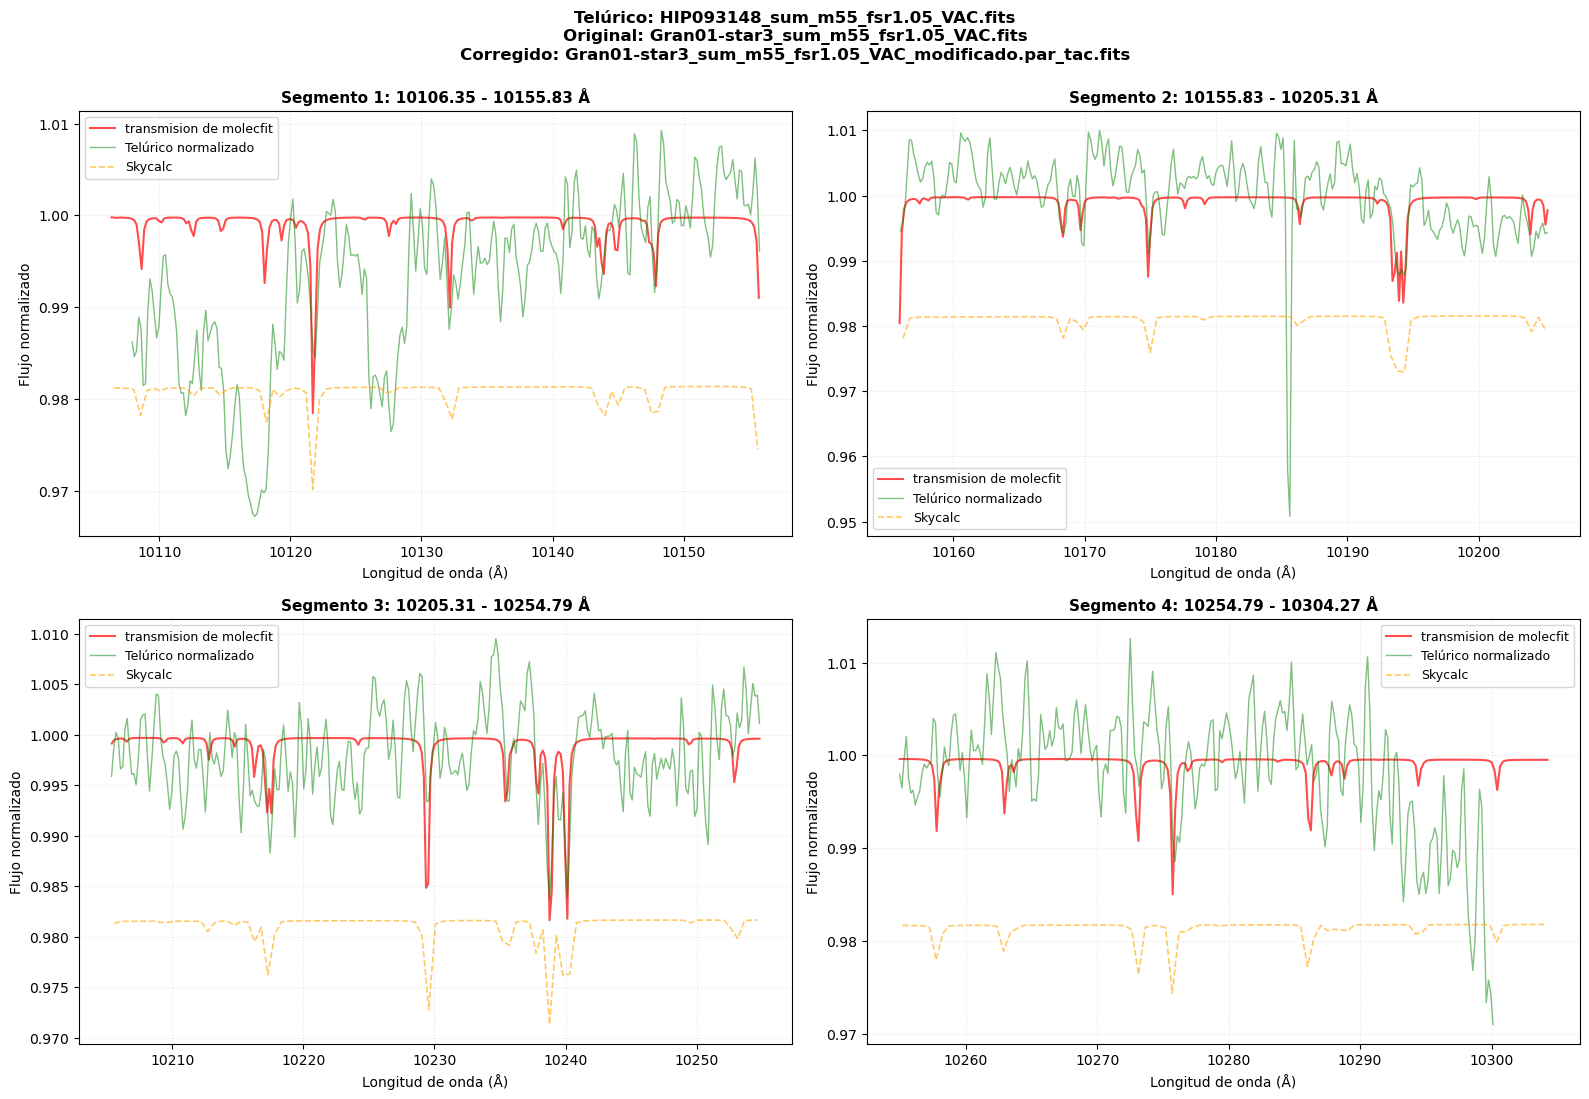

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m56_fsr1.05_VAC_comparacion_completa.png


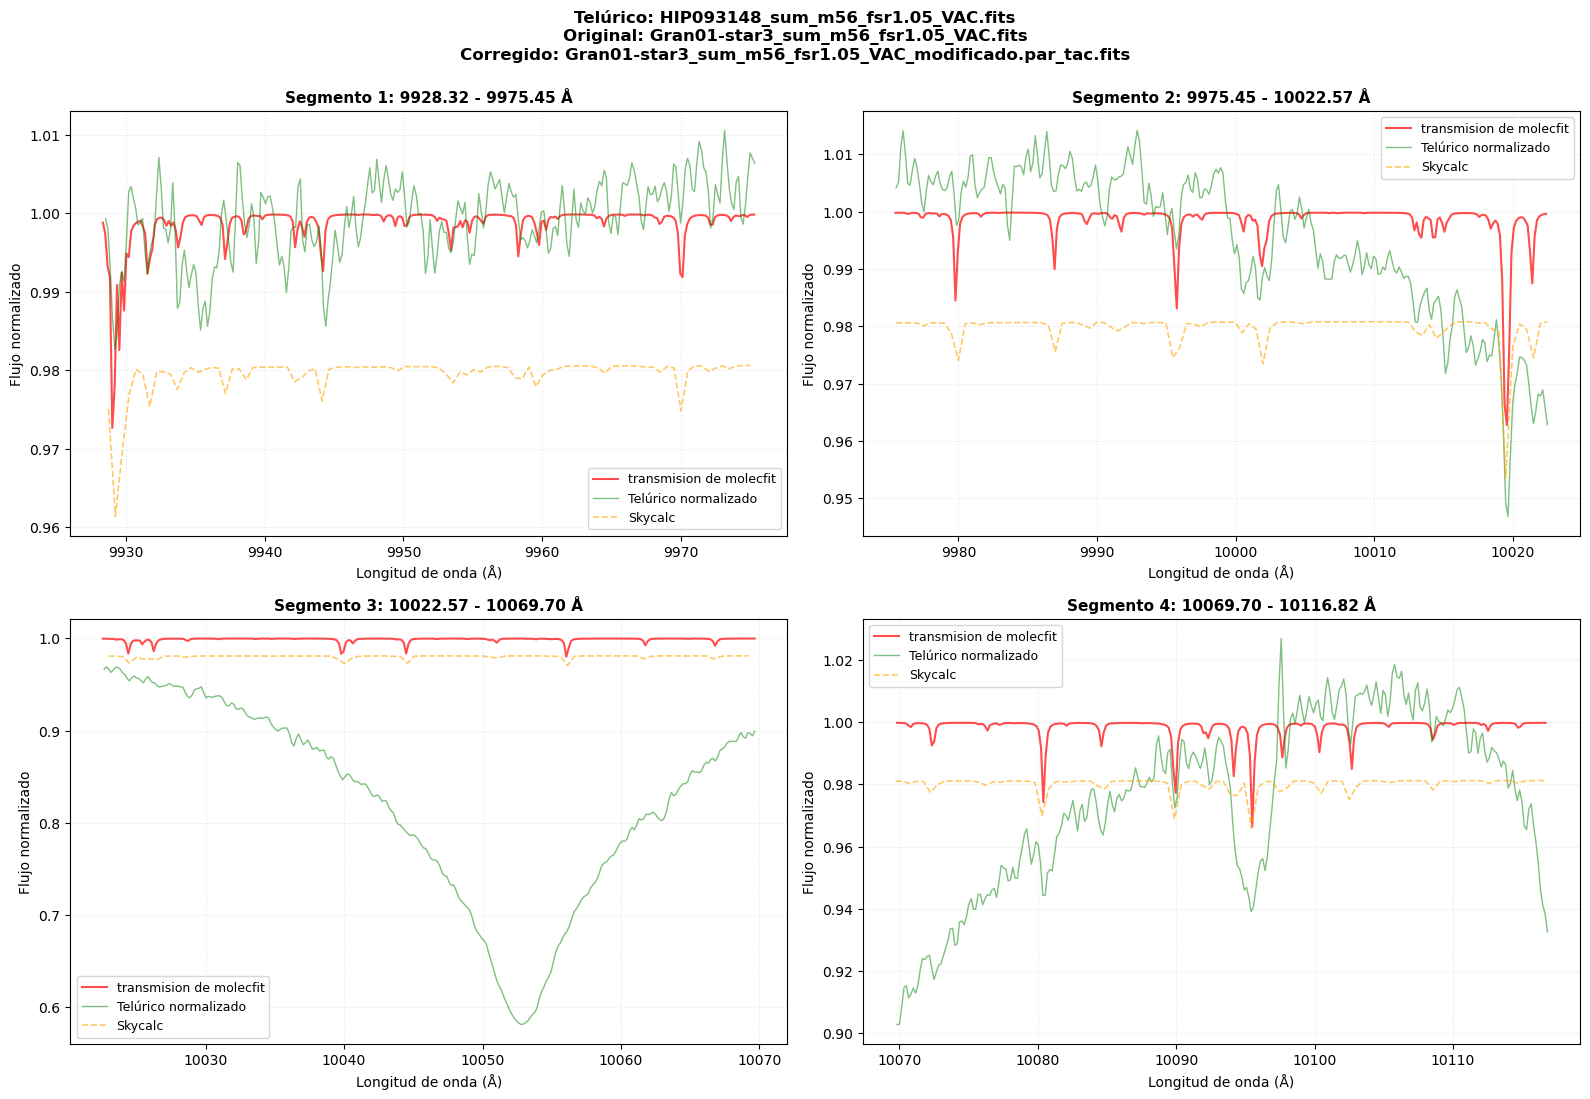

Guardado: /home/nacho/molecfit_test/comparacion_total/Gran01-star3_sum_m57_fsr1.05_VAC_comparacion_completa.png


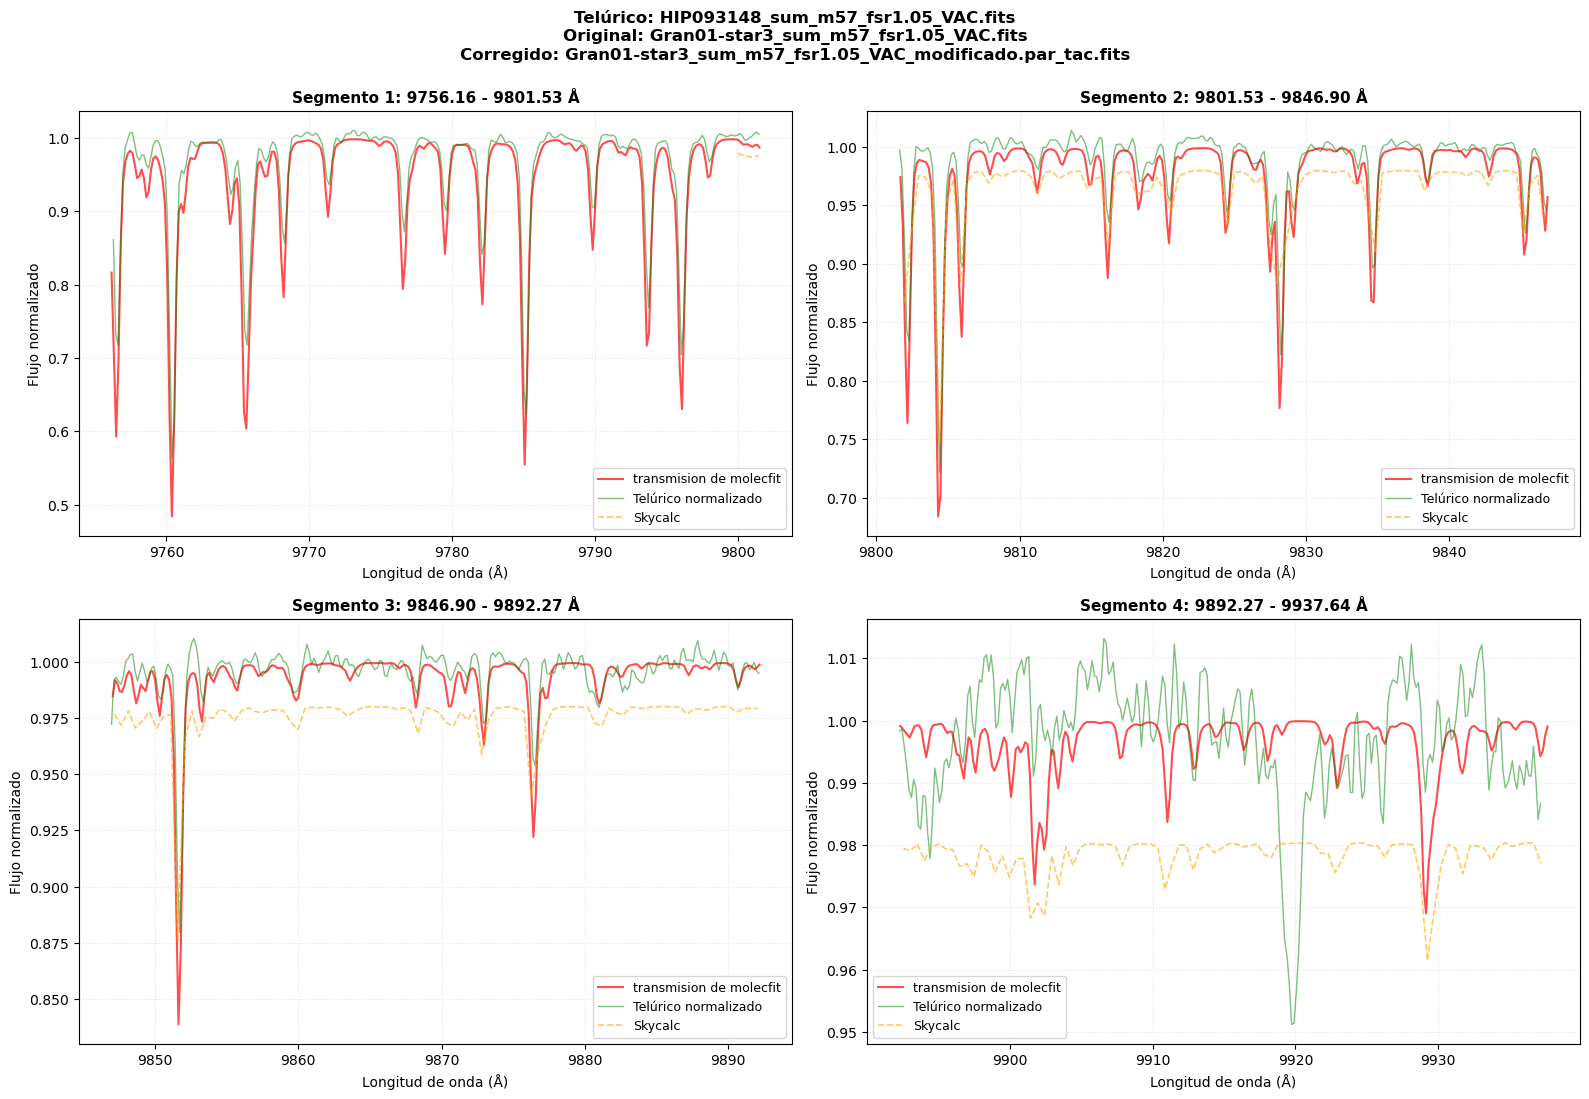

In [16]:
archivo = "/home/nacho/molecfit_test/ordenes_VACstar1/"
archivo_corr = "/home/nacho/molecfit_test/mis_outputsVAC_star1/"
ruta_telurica = "/home/nacho/molecfit_test/ordenes_telurica_utiles/"
carpeta_salida = "/home/nacho/molecfit_test/comparacion_total"
comparar_todo(archivo,archivo_corr,ruta_telurica,carpeta_salida)

Archivos telúricos: ['/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m43_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m44_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m45_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m46_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m47_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m48_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m51_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m52_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m53_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m54_fsr1.05_AIR.fits', '/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/HIP093148_sum_m

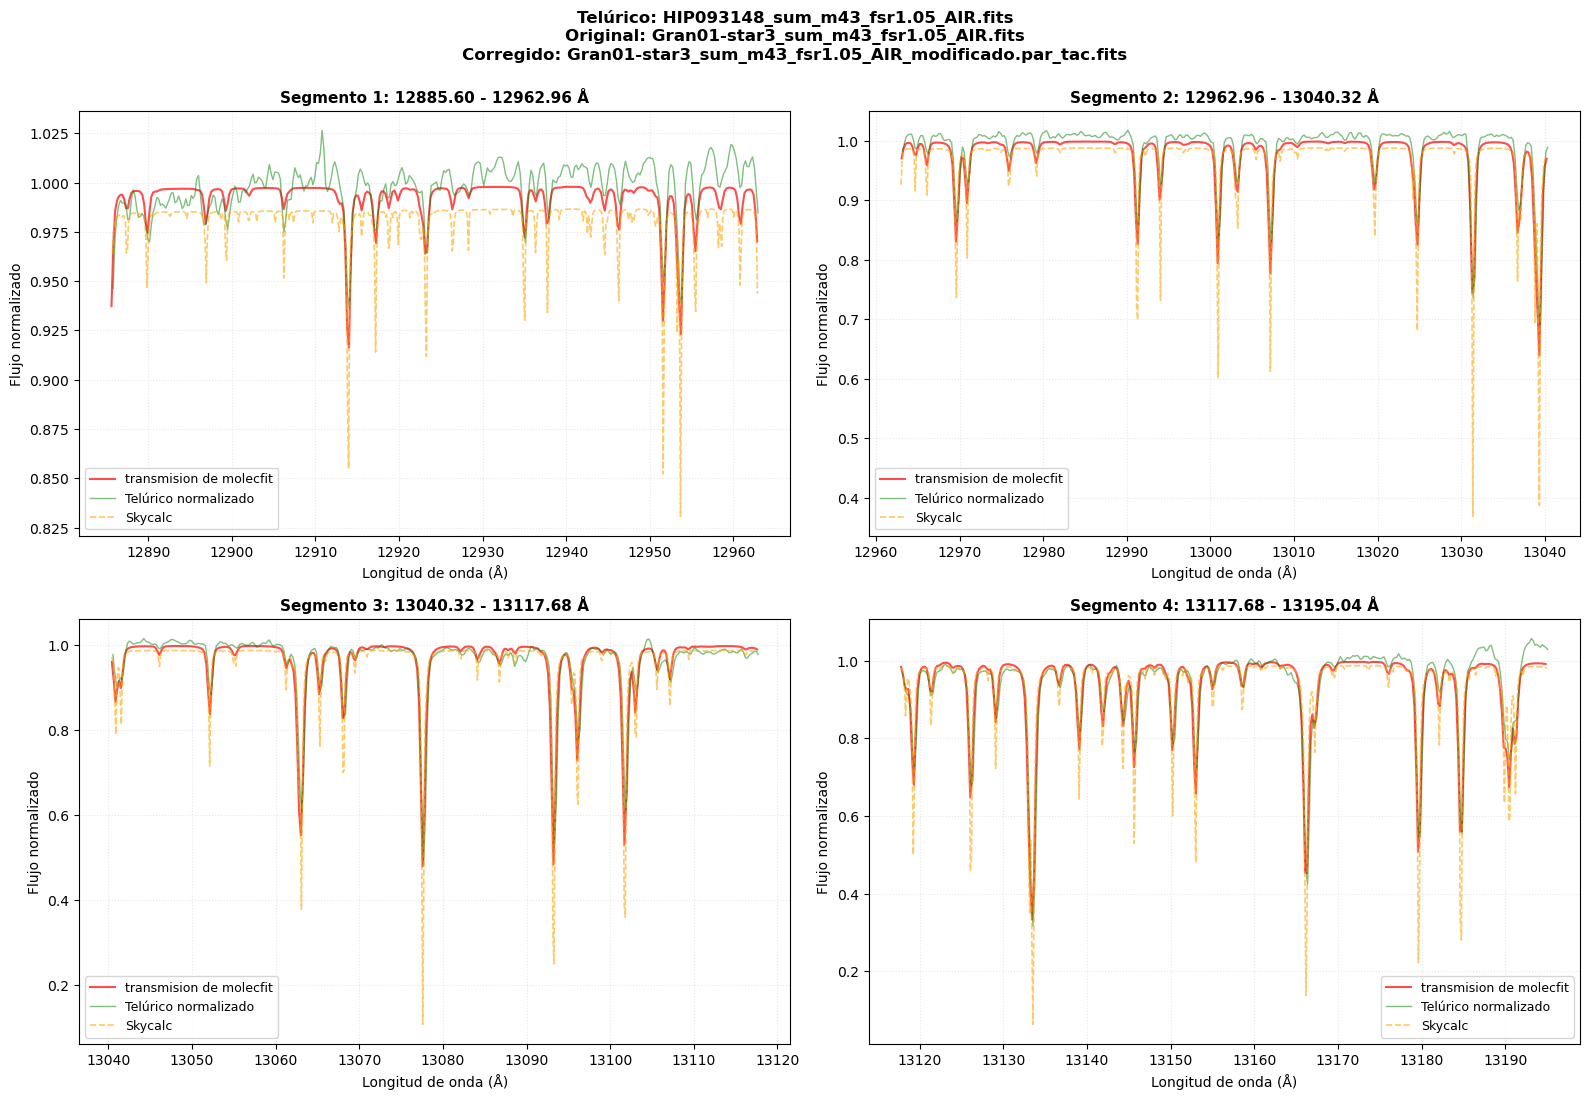


Procesando archivo calctrans: Gran01-star3_sum_m44_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 12596.41 - 12903.48 Å
el indice de refraccion es:[1.00027361 1.00027361 1.00027361 ... 1.00027357 1.00027357 1.00027357] 
    Rango DESPUÉS (aire): 12592.97 - 12899.95 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m44_fsr1.05_AIR_comparacion_completa.png


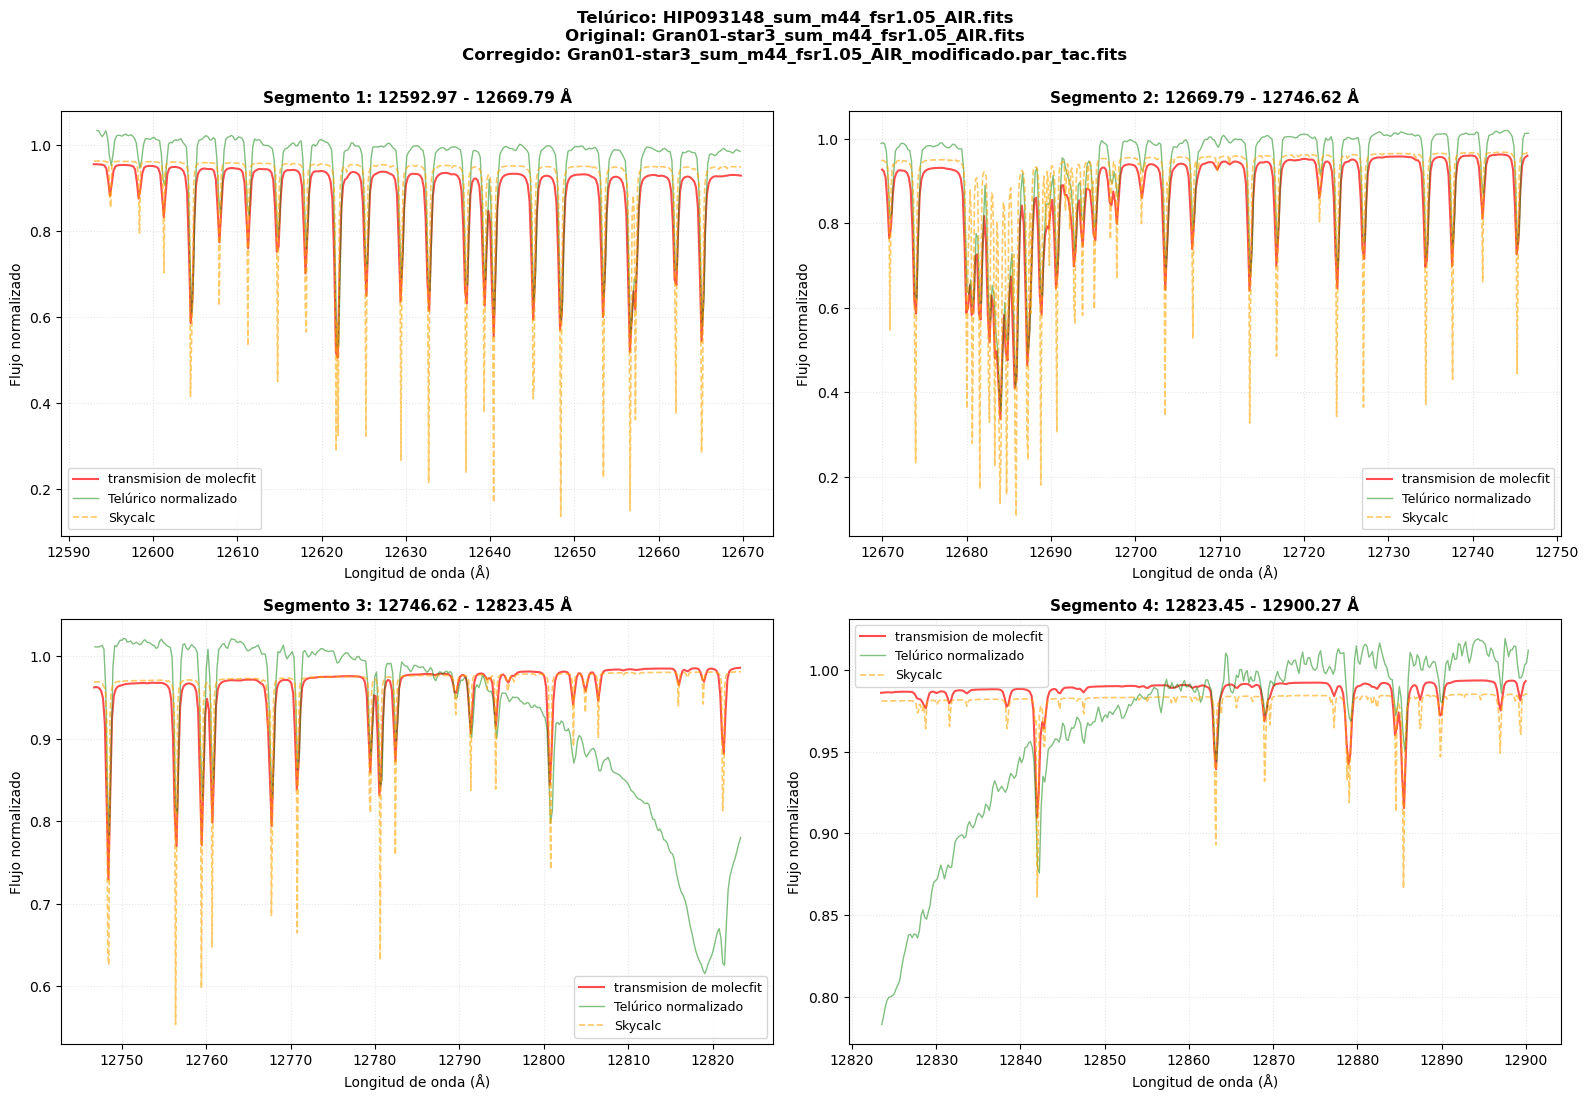


Procesando archivo calctrans: Gran01-star3_sum_m45_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 12321.81 - 12610.47 Å
el indice de refraccion es:[1.00027366 1.00027366 1.00027366 ... 1.00027361 1.00027361 1.00027361] 
    Rango DESPUÉS (aire): 12318.44 - 12607.02 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m45_fsr1.05_AIR_comparacion_completa.png


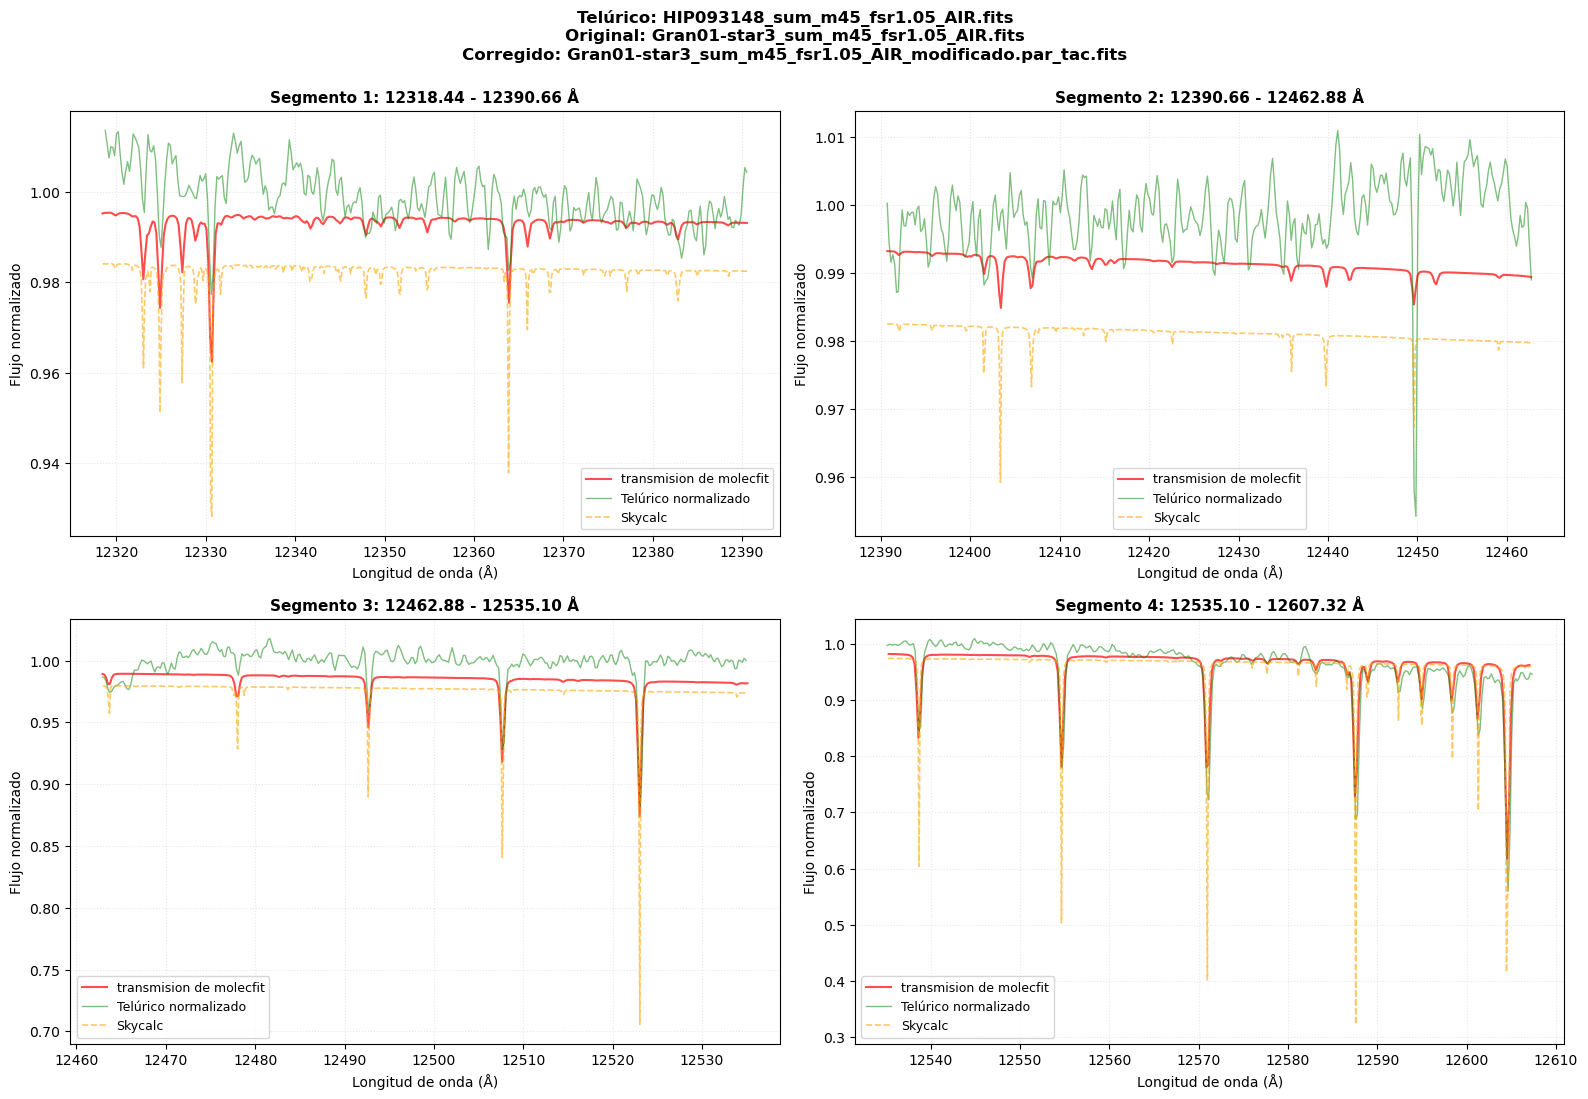


Procesando archivo calctrans: Gran01-star3_sum_m46_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 12056.92 - 12334.14 Å
el indice de refraccion es:[1.0002737  1.0002737  1.0002737  ... 1.00027365 1.00027365 1.00027365] 
    Rango DESPUÉS (aire): 12053.62 - 12330.76 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m46_fsr1.05_AIR_comparacion_completa.png


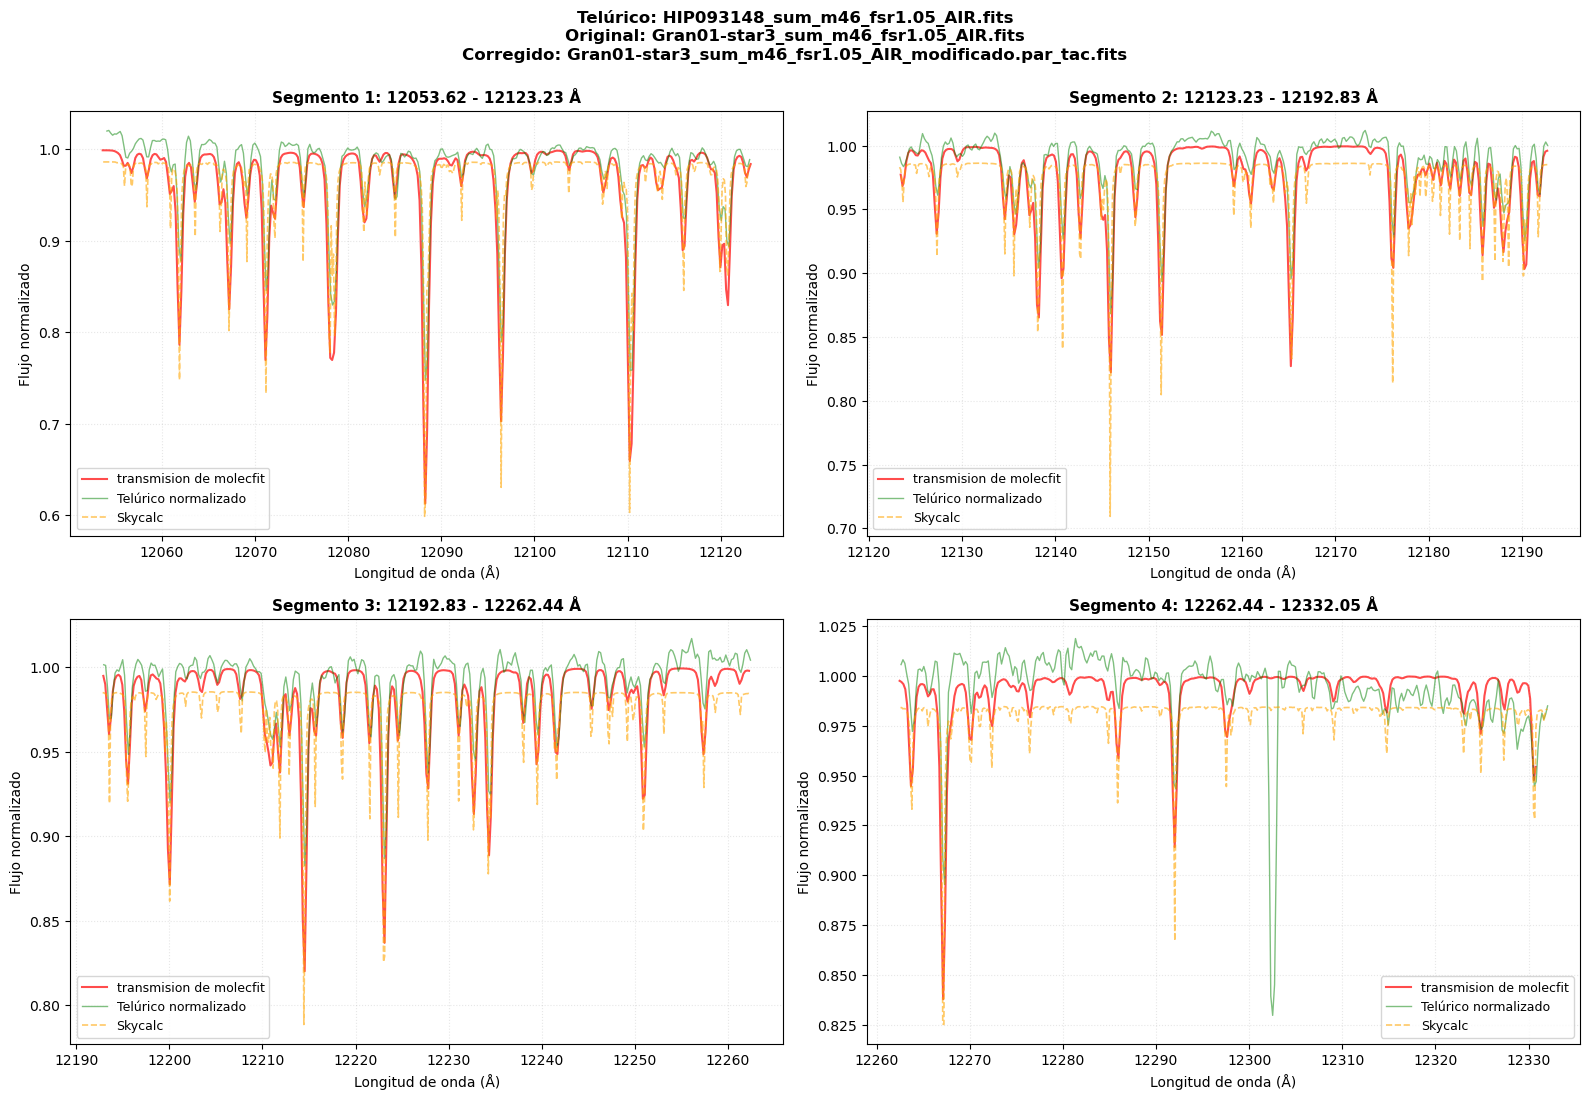


Procesando archivo calctrans: Gran01-star3_sum_m47_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 11804.35 - 12069.75 Å
el indice de refraccion es:[1.00027375 1.00027375 1.00027375 ... 1.0002737  1.0002737  1.0002737 ] 
    Rango DESPUÉS (aire): 11801.12 - 12066.44 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m47_fsr1.05_AIR_comparacion_completa.png


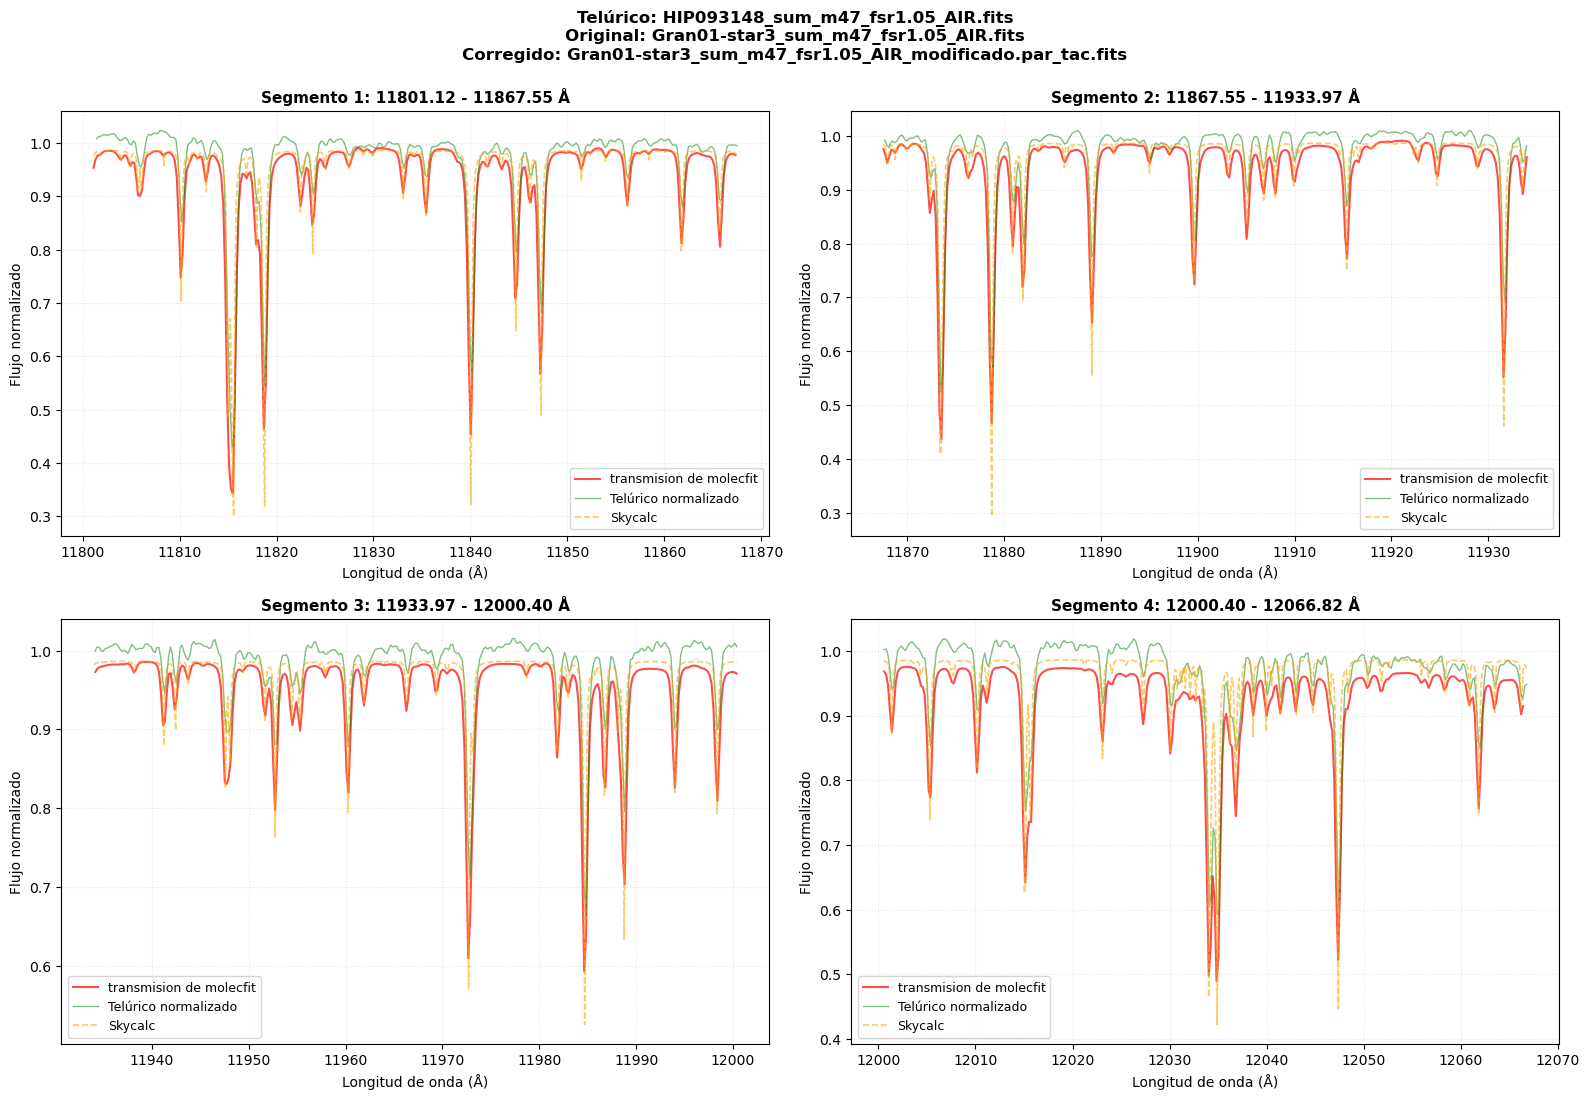


Procesando archivo calctrans: Gran01-star3_sum_m48_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 11559.27 - 11816.73 Å
el indice de refraccion es:[1.0002738  1.0002738  1.0002738  ... 1.00027375 1.00027375 1.00027375] 
    Rango DESPUÉS (aire): 11556.11 - 11813.49 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m48_fsr1.05_AIR_comparacion_completa.png


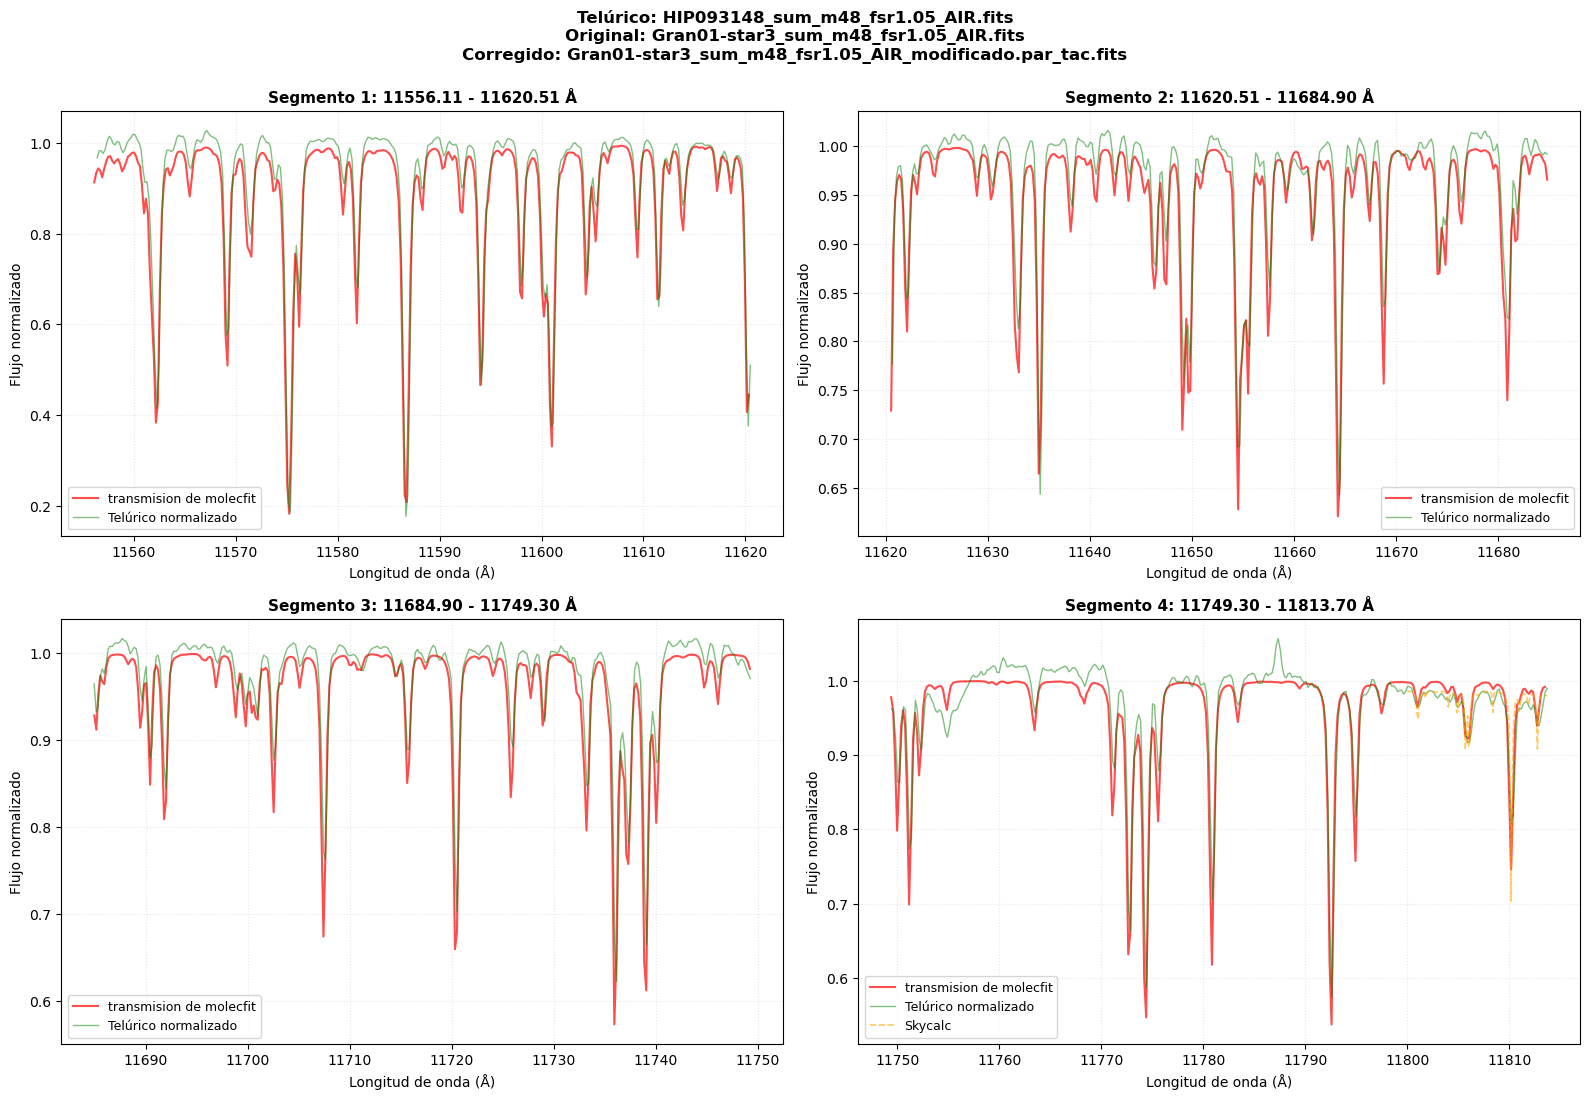


Procesando archivo calctrans: Gran01-star3_sum_m51_fsr1.05_AIR_modificado.par_tac.fits
Convirtiendo longitud de onda de vacío a aire
    Rango ANTES (vacío): 10889.87 - 11116.34 Å
el indice de refraccion es:[1.00027394 1.00027394 1.00027394 ... 1.00027389 1.00027389 1.00027389] 
    Rango DESPUÉS (aire): 10886.89 - 11113.30 Å
Guardado: /home/nacho/molecfit_test/comparacion_total_AIR/Gran01-star3_sum_m51_fsr1.05_AIR_comparacion_completa.png


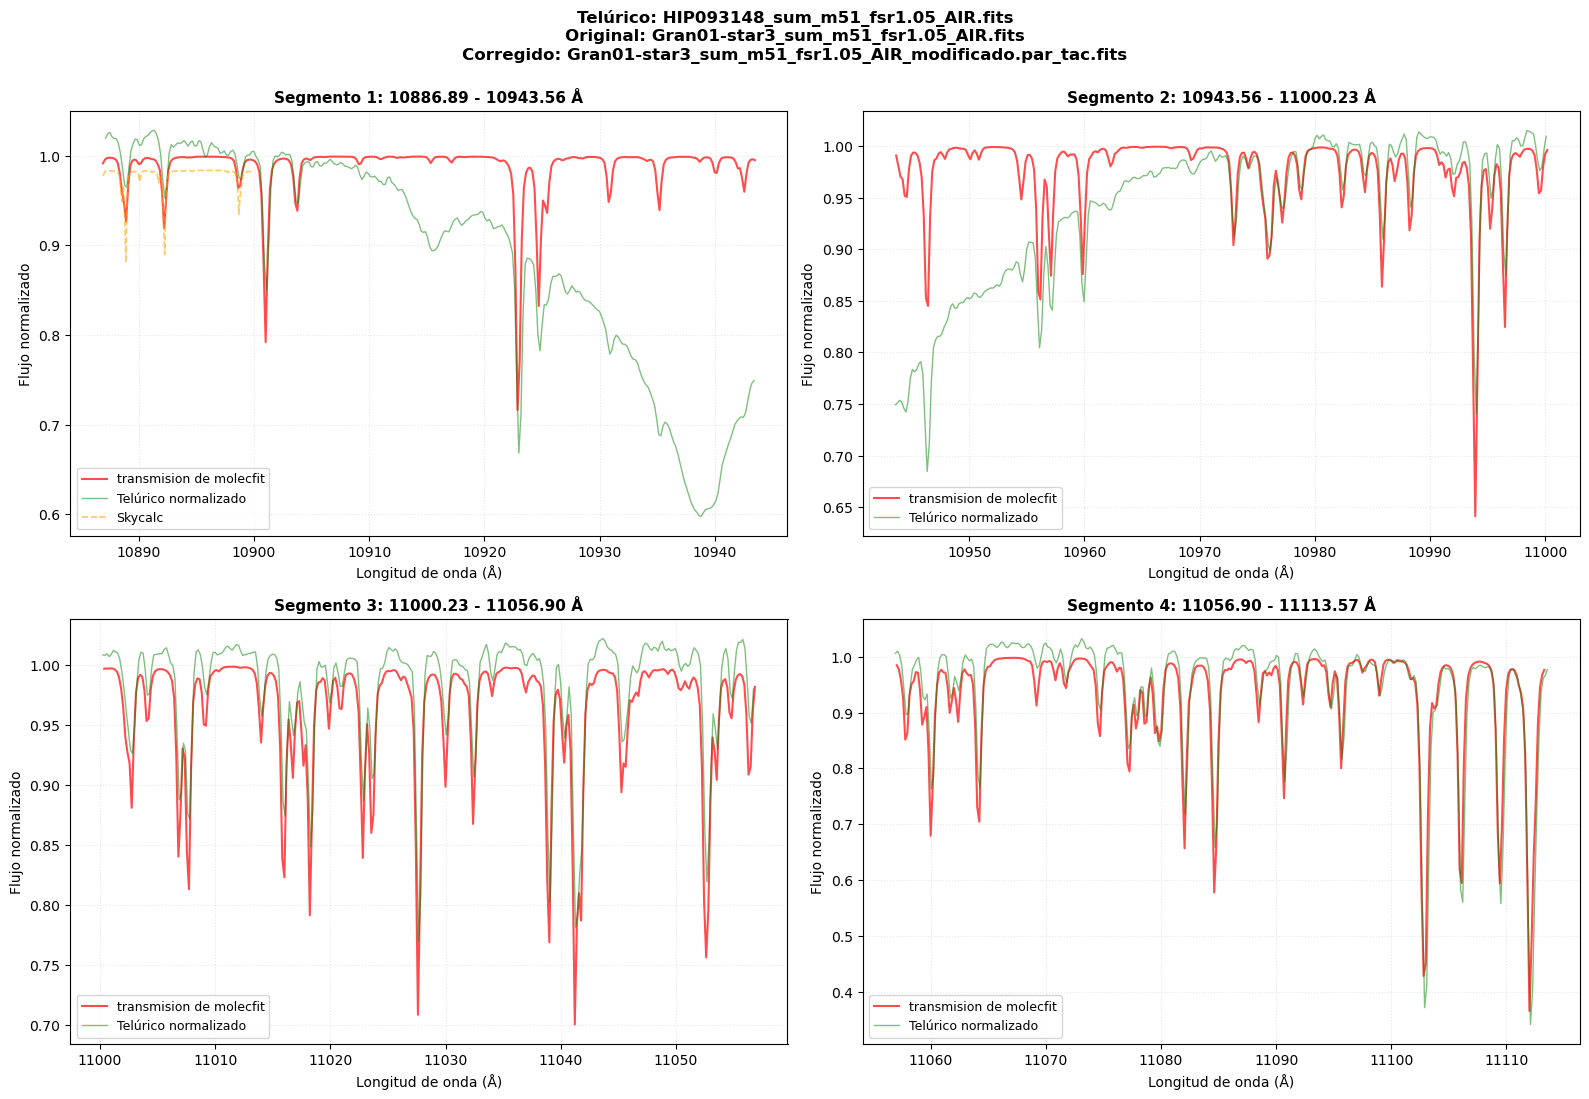

In [ ]:
archivo = "/home/nacho/molecfit_test/ordenes_star1/"
archivo_corr = "/home/nacho/molecfit_test/mis_outputs_star1/"
ruta_telurica = "/home/nacho/molecfit_test/ordenes_teluricaAIR_utiles/"
carpeta_salida = "/home/nacho/molecfit_test/comparacion_total_AIR"
comparar_todo(archivo,archivo_corr,ruta_telurica,carpeta_salida)

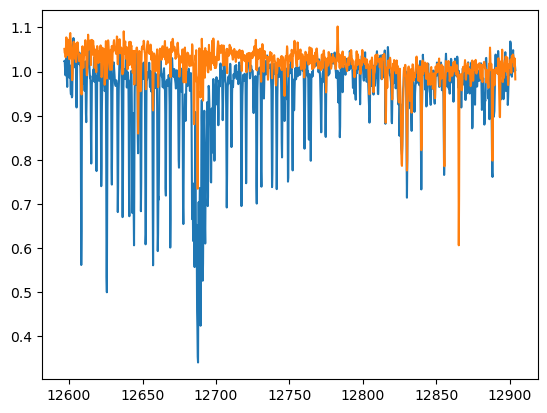

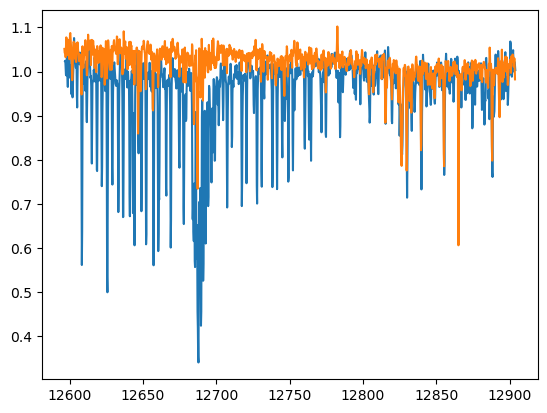

In [26]:
# ruta= "/home/nacho/molecfit_test/ordenes_star1/Gran01-star3_sum_m43_fsr1.05_AIR.fits"
# ruta_corr = "/home/nacho/molecfit_test/mis_outputs_star1/Gran01-star3_sum_m43_fsr1.05_AIR_modificado.par_tac.fits"
ruta = "/home/nacho/molecfit_test/ordenes_VACstar1/Gran01-star3_sum_m44_fsr1.05_VAC.fits"
ruta_corr = "/home/nacho/molecfit_test/mis_outputsVAC_star1/Gran01-star3_sum_m44_fsr1.05_VAC_modificado.par_tac.fits"
with fits.open(ruta) as hdul:
        data = hdul[0].data
        hdr = hdul[0].header
        n_pix = data.shape[0]
        w = WCS(hdr, naxis = 1)
        long_ond = w.pixel_to_world(np.arange(n_pix)).value
        flux_norm, y_fit, w_excl, f_excl =\
            continuum(long_ond,data,low_rej=1.8,high_re=0.0,niter=10,order=3,plots=False)
with fits.open(ruta_corr) as h:
    data = h[1].data
    flux = data['CFLUX']
    long_corr = data['LAMBDA']*1e4
    
long,flux_or = extraer_datos_originales(ruta)
longcor,fluxcor = extraer_datos_calctrans(ruta_corr)

plt.plot(long_ond,flux_norm)
plt.plot(long_corr,flux)
plt.show()
plt.plot(long,flux_or)
plt.plot(longcor,fluxcor)

plt.show()